In [1]:
import os

import kagglehub

import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import numpy as np

# Датасет регрессии

## Описание датасета

battery_id: Unique identifier for each battery.

manufacturer: Battery manufacturer (Tesla, Panasonic, LG Chem, CATL, BYD, Samsung SDI).

chemistry: Battery chemistry (NMC, LFP, NCA).

capacity_kWh: Nominal battery capacity in kilowatt-hours (40–120 kWh).

charge_cycles: Number of full charge–discharge cycles (50–3000).

avg_temp_celsius: Average operating temperature in °C (–10 to 50).

discharge_rate_c: Typical discharge rate in C (0.5–5).

charge_rate_c: Typical charge rate in C (0.5–3).

avg_soc_percent: Average state of charge during use (10–90%).

storage_time_months: Months battery spent in storage before use (0–24).

fast_charge_ratio: Fraction of charging events that were fast charging (0–1).

calendar_age_years: Age since manufacturing (0.1–12 years).

capacity_retained_percent (target variable): Actual remaining capacity (%) relative to nominal capacity.

“C-rate” is a unit that measures the rate of charging or discharging relative to the battery’s capacity.

1C means the current will charge or discharge the battery in 1 hour.

Example: A 1000 mAh (1 Ah) battery at 1C = 1 A current → full discharge in 1 h.

0.5C = half of the capacity per hour.

## Обоснование выбора

На текущий момент электрокары стремительно входят в использование, особенно в крупных городах, т.к. считаются более экологичной альтернативой - к примеру, в Китае стремительно происходит переход на них. Т.к. батарея электокара составляет основную часть его стоимости, то определение долгосрочности работы батареи является ценной задачей.

## Анализ и обработка датасета

### Загрузим датасет через kagglehub

In [2]:
dataset_path = kagglehub.dataset_download('sahilbarke/ev-battery-dataset')

In [3]:
filename = os.listdir(dataset_path)[0]

In [4]:
df = pd.read_csv(os.path.join(dataset_path,filename))

### Рассмотрим датасет

In [5]:
len(df)

15000

In [6]:
df.head()

,battery_id,manufacturer,chemistry,capacity_kWh,charge_cycles,avg_temp_celsius,discharge_rate_c,charge_rate_c,avg_soc_percent,storage_time_months,fast_charge_ratio,calendar_age_years,capacity_retained_percent
0,BAT000001,Panasonic,NMC,65.54,1524.0,26.61,1.507,0.500,51.96,0.1,0.155,1.58,81.75
1,BAT000002,Samsung SDI,LFP,NaN,1072.0,16.82,0.850,0.927,80.76,11.0,0.466,3.44,81.93
2,BAT000003,BYD,LFP,99.99,807.0,6.27,0.751,1.232,74.73,3.5,0.058,0.23,89.75
3,BAT000004,CATL,NMC,85.96,681.0,28.65,0.788,1.070,30.95,0.2,0.332,3.43,84.41
4,BAT000005,Tesla,NMC,69.85,476.0,41.57,0.683,0.607,59.67,3.6,0.307,0.34,87.04


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   battery_id                 15000 non-null  object 
 1   manufacturer               14315 non-null  object 
 2   chemistry                  14256 non-null  object 
 3   capacity_kWh               14268 non-null  float64
 4   charge_cycles              14311 non-null  float64
 5   avg_temp_celsius           14282 non-null  float64
 6   discharge_rate_c           14280 non-null  float64
 7   charge_rate_c              14289 non-null  float64
 8   avg_soc_percent            14241 non-null  float64
 9   storage_time_months        14259 non-null  float64
 10  fast_charge_ratio          14254 non-null  float64
 11  calendar_age_years         14203 non-null  float64
 12  capacity_retained_percent  14249 non-null  float64
dtypes: float64(10), object(3)
memory usage: 1.5+ M

In [8]:
df.isnull().sum()

battery_id                     0
manufacturer                 685
chemistry                    744
capacity_kWh                 732
charge_cycles                689
avg_temp_celsius             718
discharge_rate_c             720
charge_rate_c                711
avg_soc_percent              759
storage_time_months          741
fast_charge_ratio            746
calendar_age_years           797
capacity_retained_percent    751
dtype: int64

In [9]:
df.describe(include='all')

,battery_id,manufacturer,chemistry,capacity_kWh,charge_cycles,avg_temp_celsius,discharge_rate_c,charge_rate_c,avg_soc_percent,storage_time_months,fast_charge_ratio,calendar_age_years,capacity_retained_percent
count,15000,14315,14256,14268.000000,14311.000000,14282.000000,14280.000000,14289.000000,14241.000000,14259.000000,14254.000000,14203.000000,14249.000000
unique,15000,6,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,BAT015000,Tesla,NMC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,2901,7784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,74.831688,724.540354,24.836594,1.060485,1.017919,55.178979,3.962192,0.273791,1.997541,87.059668
std,NaN,NaN,NaN,14.809087,398.426835,8.644186,0.498338,0.360305,14.923134,3.957581,0.175465,1.977227,6.587419
min,NaN,NaN,NaN,40.000000,50.000000,-9.940000,0.500000,0.500000,10.000000,0.000000,0.000000,0.100000,25.010000
25%,NaN,NaN,NaN,64.507500,467.500000,19.940000,0.584000,0.731000,45.040000,1.100000,0.132000,0.570000,84.000000
50%,NaN,NaN,NaN,74.900000,655.000000,25.030000,0.989000,0.997000,55.410000,2.700000,0.245000,1.380000,87.840000
75%,NaN,NaN,NaN,85.030000,880.000000,30.070000,1.393000,1.267000,65.430000,5.500000,0.390000,2.770000,91.050000


In [10]:
TARGET_NAME = "capacity_retained_percent"

### Сохраним необработанный датасет

Все пропущенные значения вырезаем, категориальные переменные отбрасываем

In [11]:
df_raw = df.dropna()

In [12]:
df_raw[df_raw.select_dtypes(include=["int64", "float64"]).columns.to_list()].drop(columns=TARGET_NAME).to_csv("regression_raw_feats.csv", index=False)

In [13]:
df_raw[[TARGET_NAME]].to_csv('regression_raw_target.csv', index=False)

### Разберёмся с пропусками

#### Проверим, есть ли корреляция между пропусками

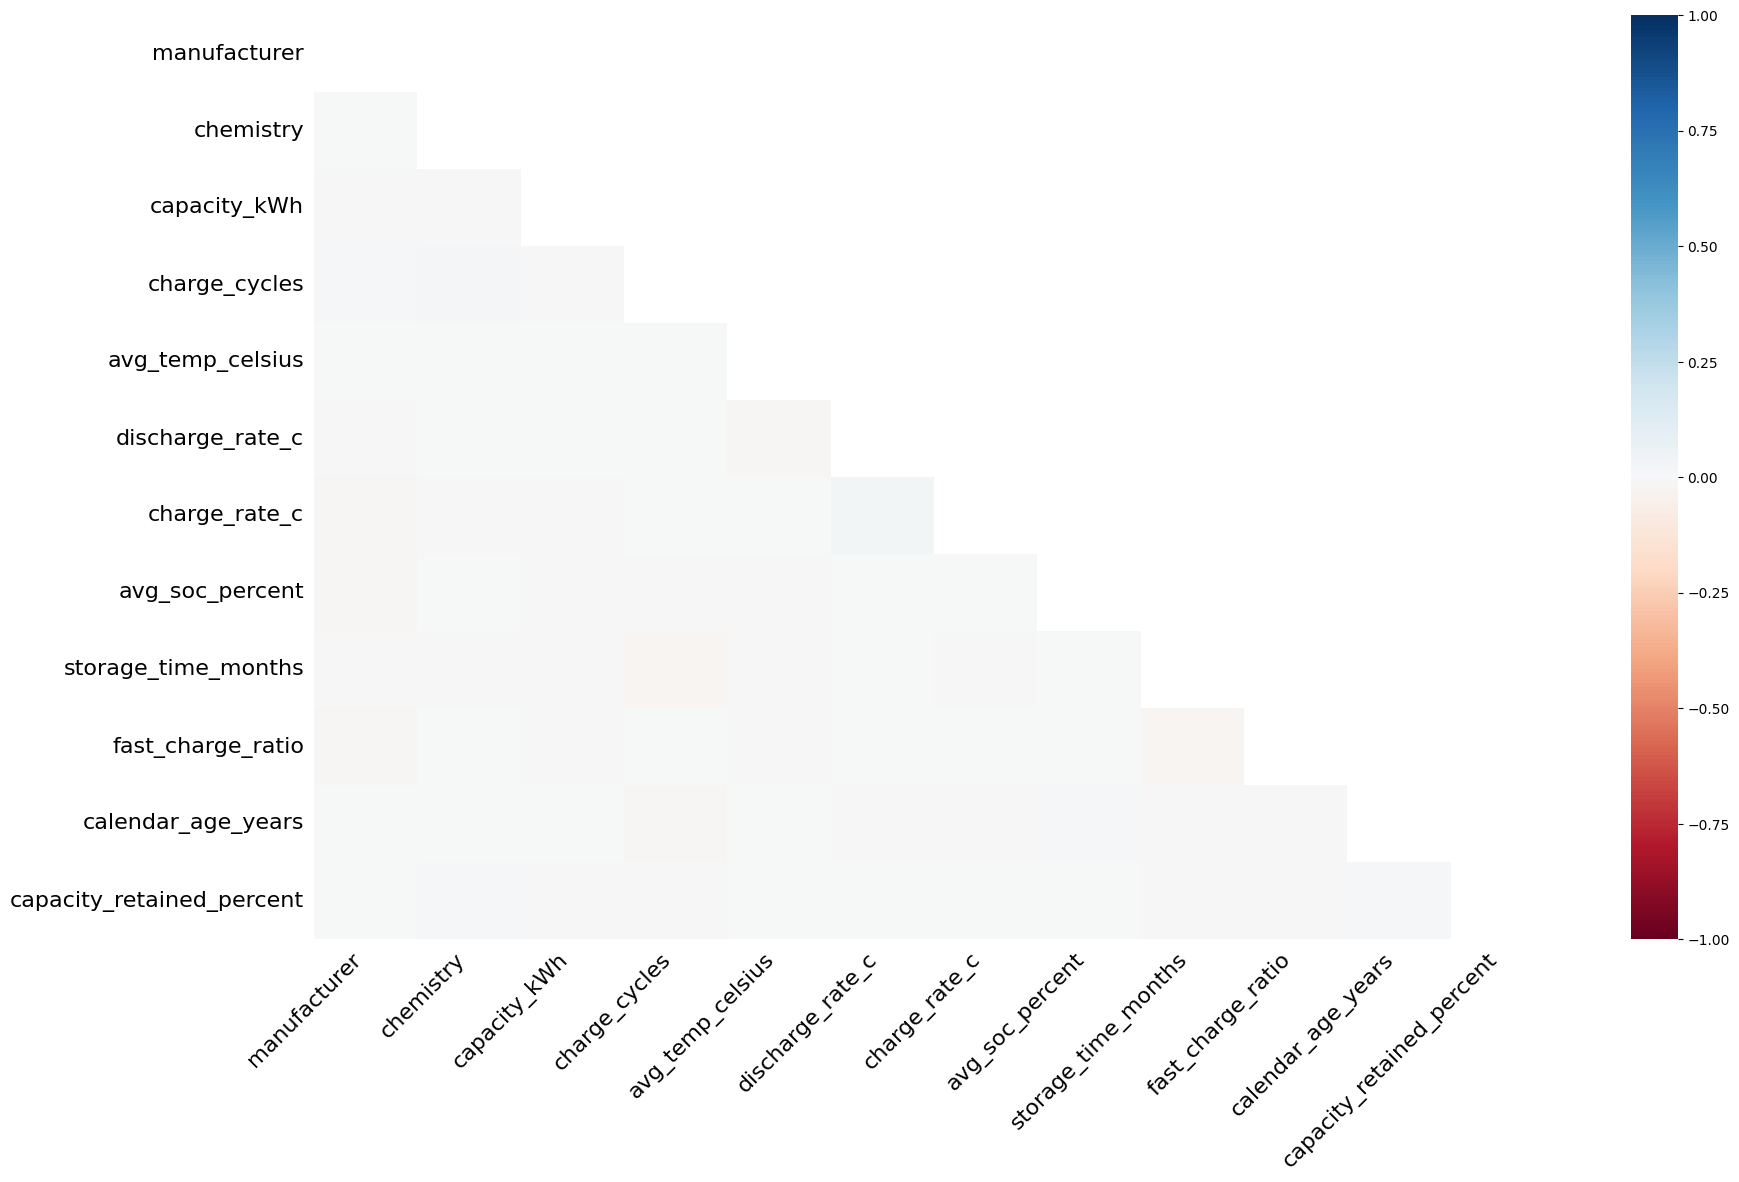

In [14]:
msno.heatmap(df)
plt.show()

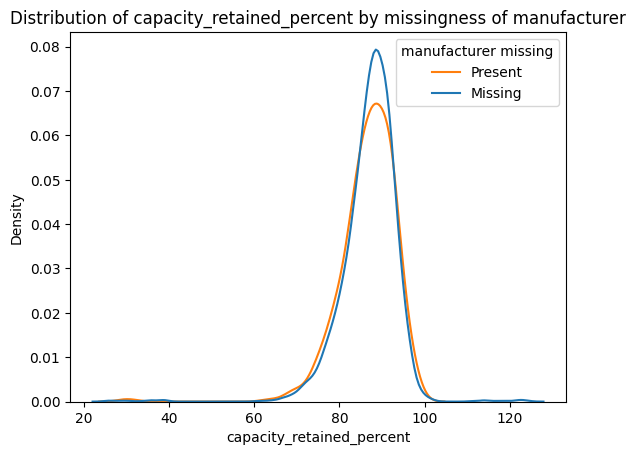

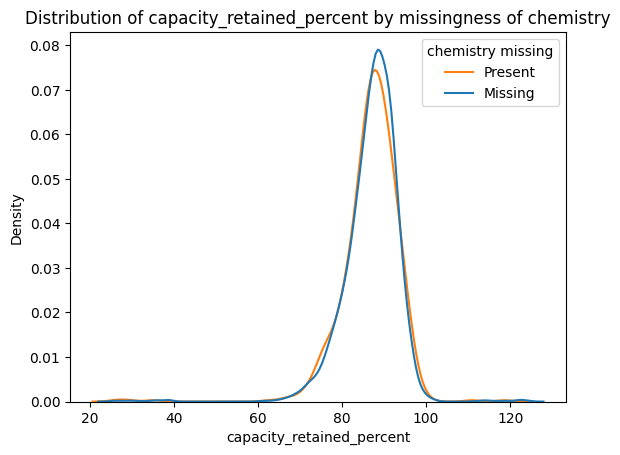

In [15]:
categorical_features = df.select_dtypes(include=["object"]).columns.to_list()
categorical_features.remove("battery_id")

for categorical_feature in categorical_features:
    df['missing'] = df[categorical_feature].isnull()

    sns.kdeplot(data=df, x=TARGET_NAME, hue='missing', common_norm=False)
    plt.title(f'Distribution of {TARGET_NAME} by missingness of {categorical_feature}')
    plt.legend(title=categorical_feature+' missing', labels=['Present', 'Missing'])
    plt.show()

In [16]:
df.drop(columns=['missing'], inplace=True)

Вывод: корреляции нет

#### Численные пропуски заполним медианным значением

In [17]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
numeric_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])

#### Сделаем mode impute для категориальных данных

In [18]:
category_columns = df.select_dtypes(include=['object']).columns
cate_imputer = SimpleImputer(strategy='most_frequent')
df[category_columns] = cate_imputer.fit_transform(df[category_columns])

In [19]:
df.isnull().sum()

battery_id                   0
manufacturer                 0
chemistry                    0
capacity_kWh                 0
charge_cycles                0
avg_temp_celsius             0
discharge_rate_c             0
charge_rate_c                0
avg_soc_percent              0
storage_time_months          0
fast_charge_ratio            0
calendar_age_years           0
capacity_retained_percent    0
dtype: int64

In [20]:
len(df)

15000

### Почистим и преобразуем данные

In [21]:
df.describe()

,capacity_kWh,charge_cycles,avg_temp_celsius,discharge_rate_c,charge_rate_c,avg_soc_percent,storage_time_months,fast_charge_ratio,calendar_age_years,capacity_retained_percent
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,74.835022,721.346133,24.845851,1.057054,1.016928,55.190669,3.899840,0.272359,1.964729,87.098737
std,14.443209,389.440312,8.434852,0.486470,0.351690,14.540740,3.868267,0.171160,1.928958,6.422640
min,40.000000,50.000000,-9.940000,0.500000,0.500000,10.000000,0.000000,0.000000,0.100000,25.010000
25%,65.150000,477.000000,20.260000,0.608000,0.746000,45.730000,1.200000,0.137000,0.600000,84.250000
50%,74.900000,655.000000,25.030000,0.989000,0.997000,55.410000,2.700000,0.245000,1.380000,87.840000
75%,84.392500,865.000000,29.780000,1.368000,1.252000,64.830000,5.300000,0.380000,2.670000,90.860000
max,120.000000,2898.000000,50.000000,3.303000,2.534000,90.000000,24.000000,0.938000,12.000000,124.990000


#### Наиболее явный выброс - остаток ёмкости батареи больше 100%

In [22]:
len(df[df[TARGET_NAME] > 100.0])

69

In [23]:
df = df[df[TARGET_NAME] <= 100.0]

#### Уберём id

In [24]:
df.drop(columns=['battery_id'], inplace=True)

#### Сделаем one-hot encoding

In [25]:
df_onehot = pd.get_dummies(df, drop_first=True, dtype=int)

### Рассмотрим распределения величин

#### Численные величины

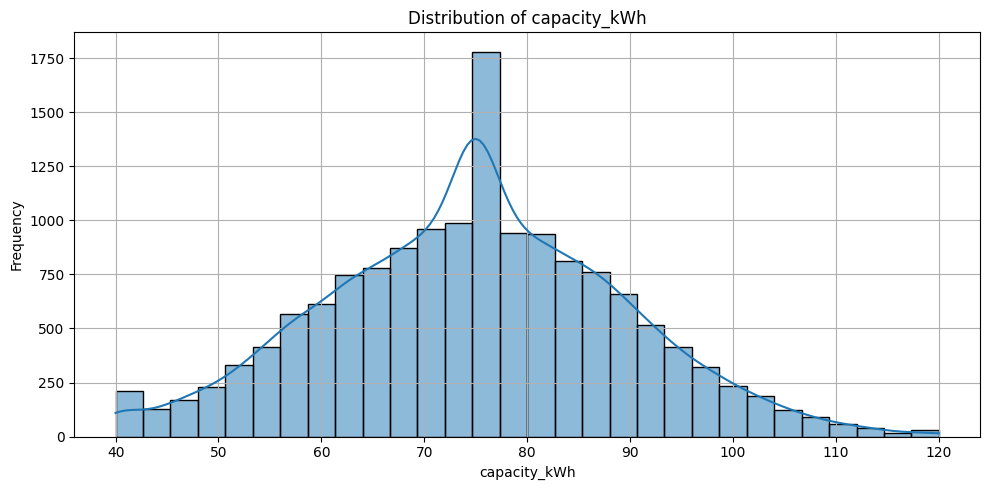

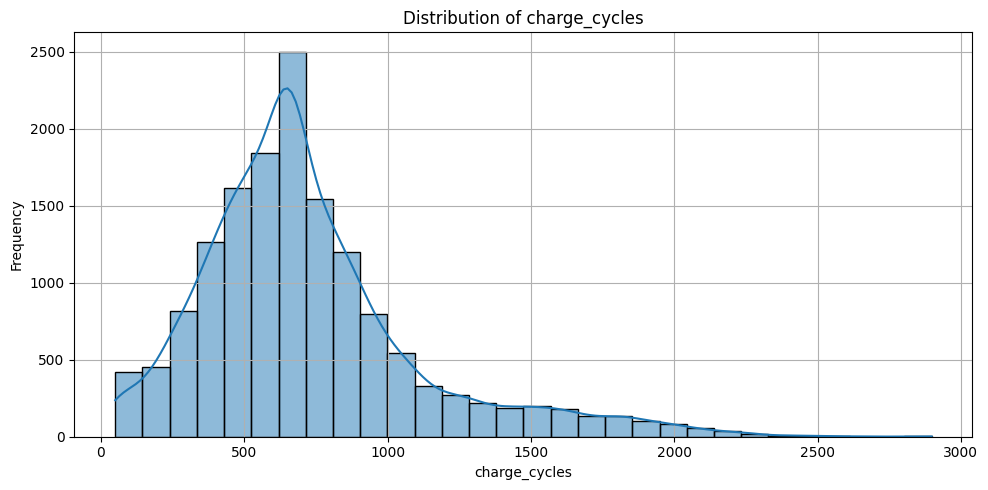

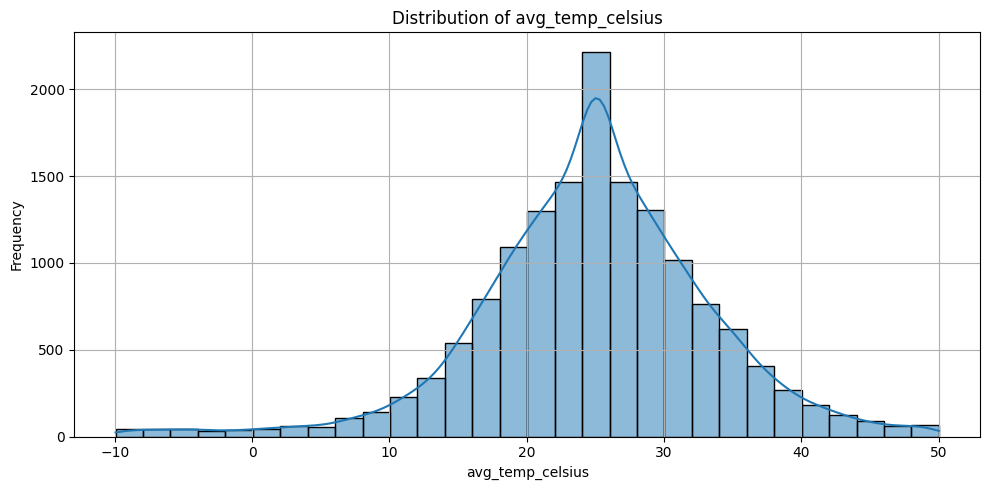

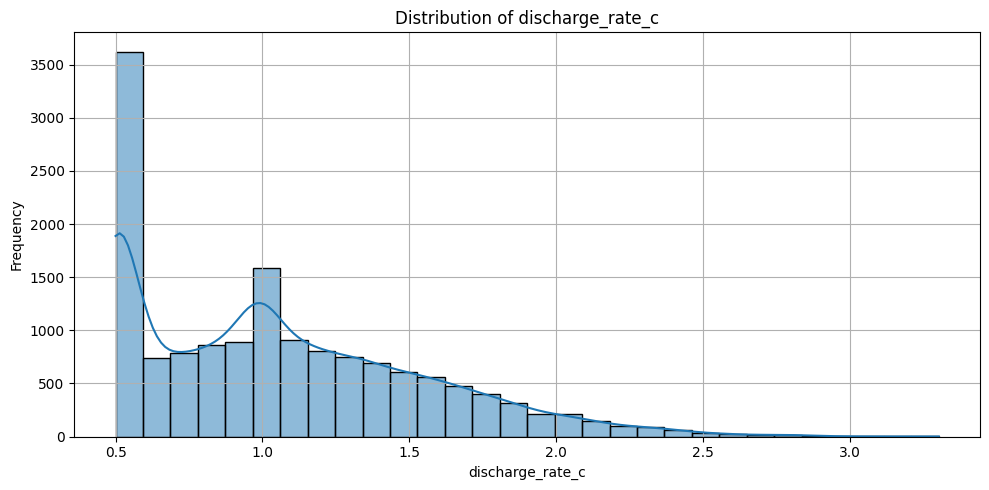

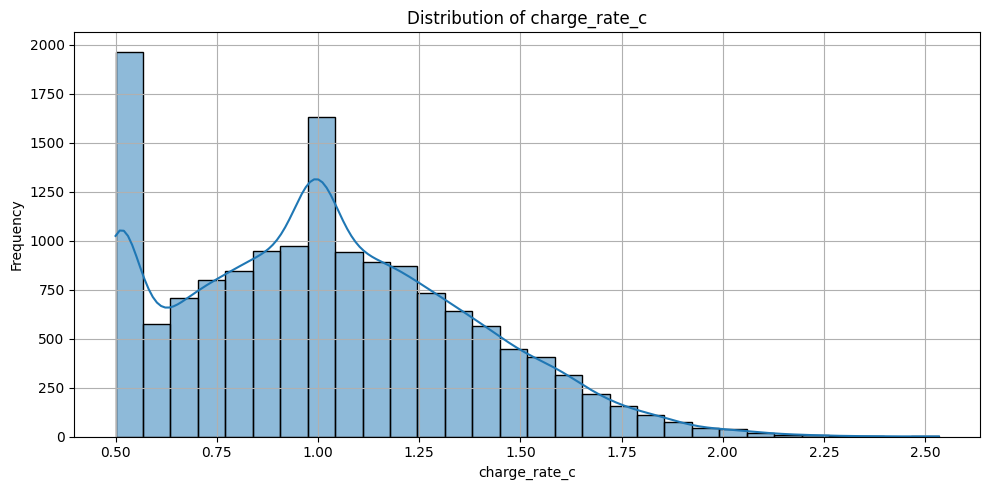

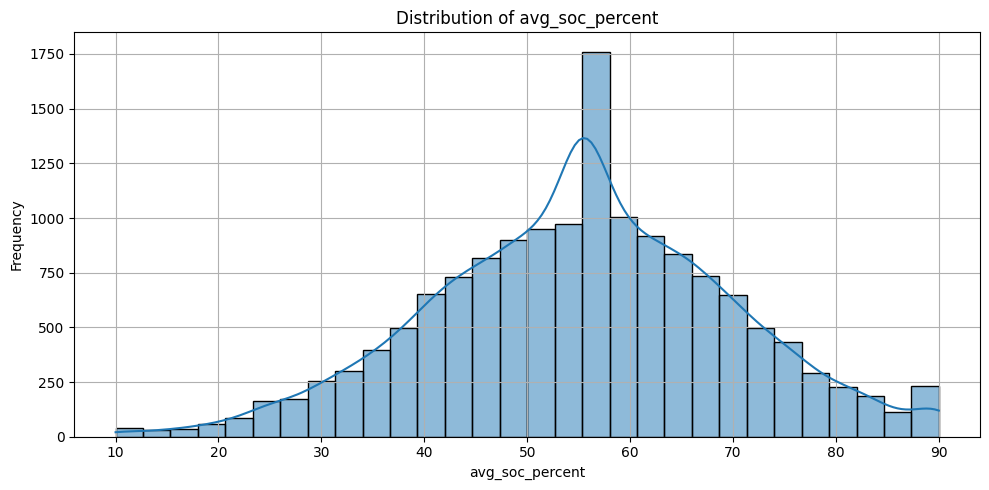

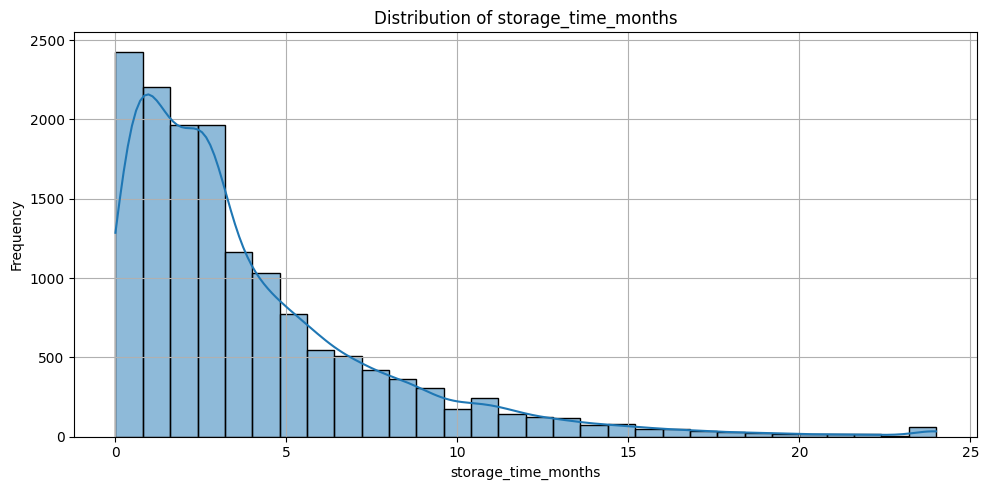

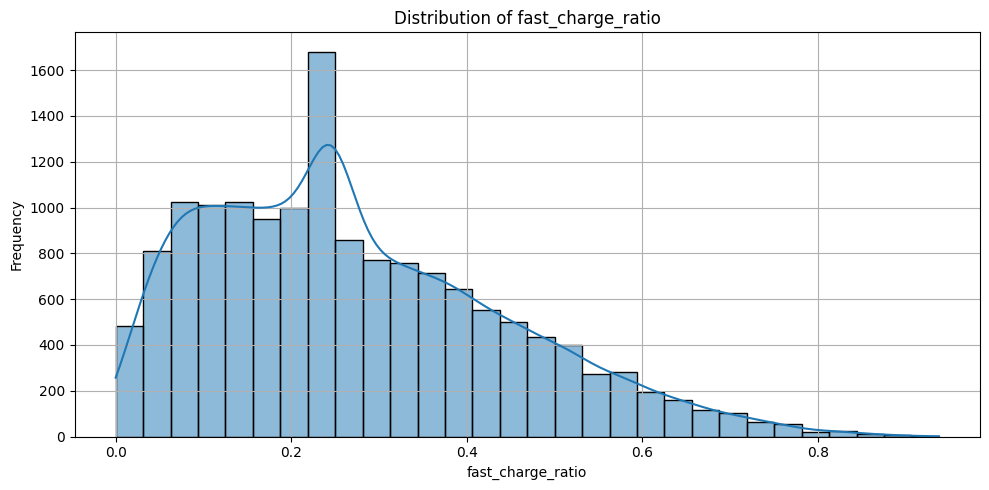

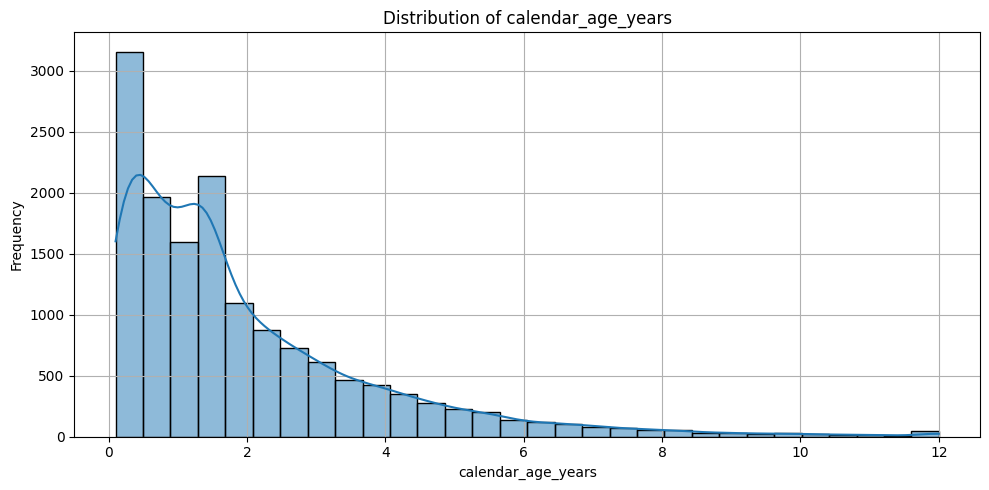

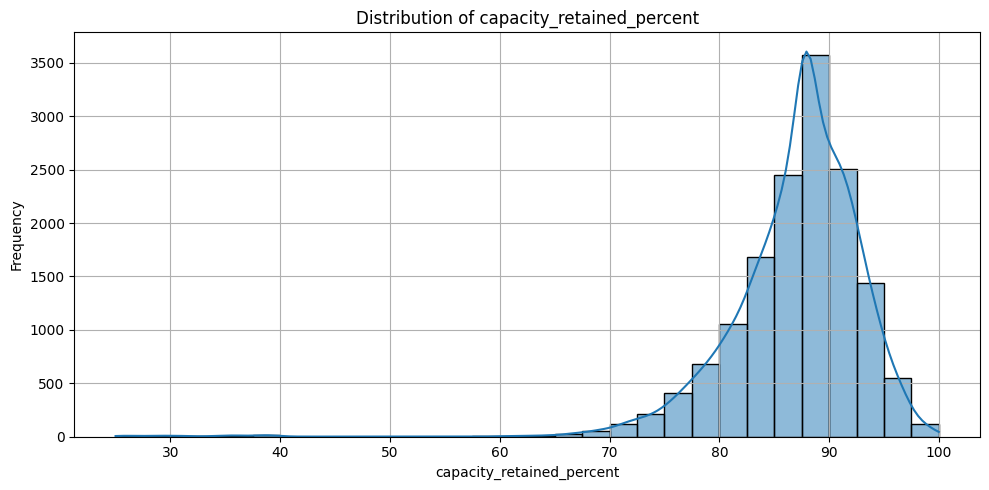

In [26]:
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.to_list()

for col in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Категориальные величины

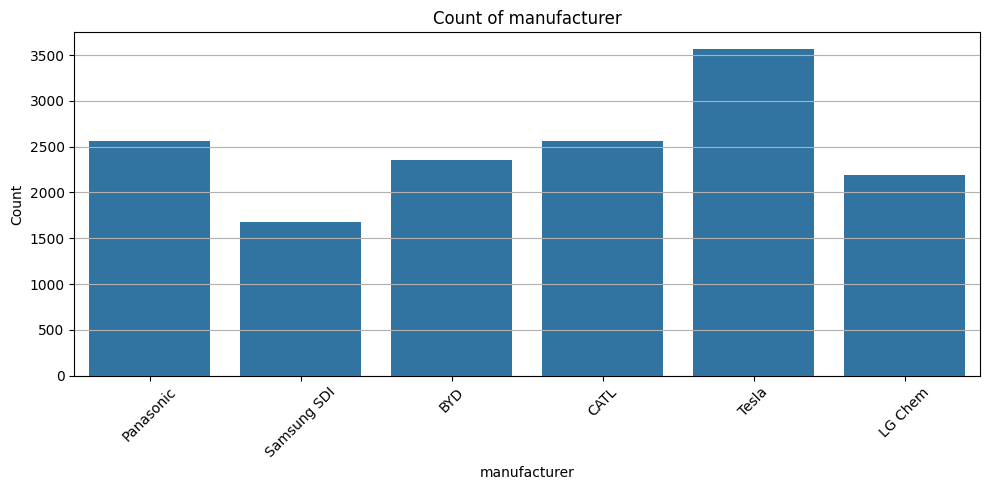

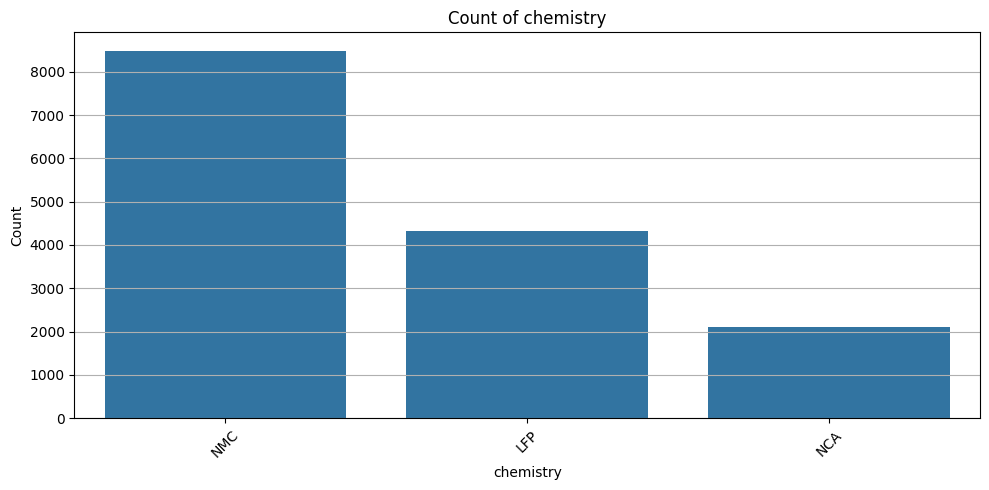

In [27]:
categorical_features = df.select_dtypes(include=["object"]).columns.to_list()

for col in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=df[col])
    plt.title(f"Count of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

#### Матрица корреляции

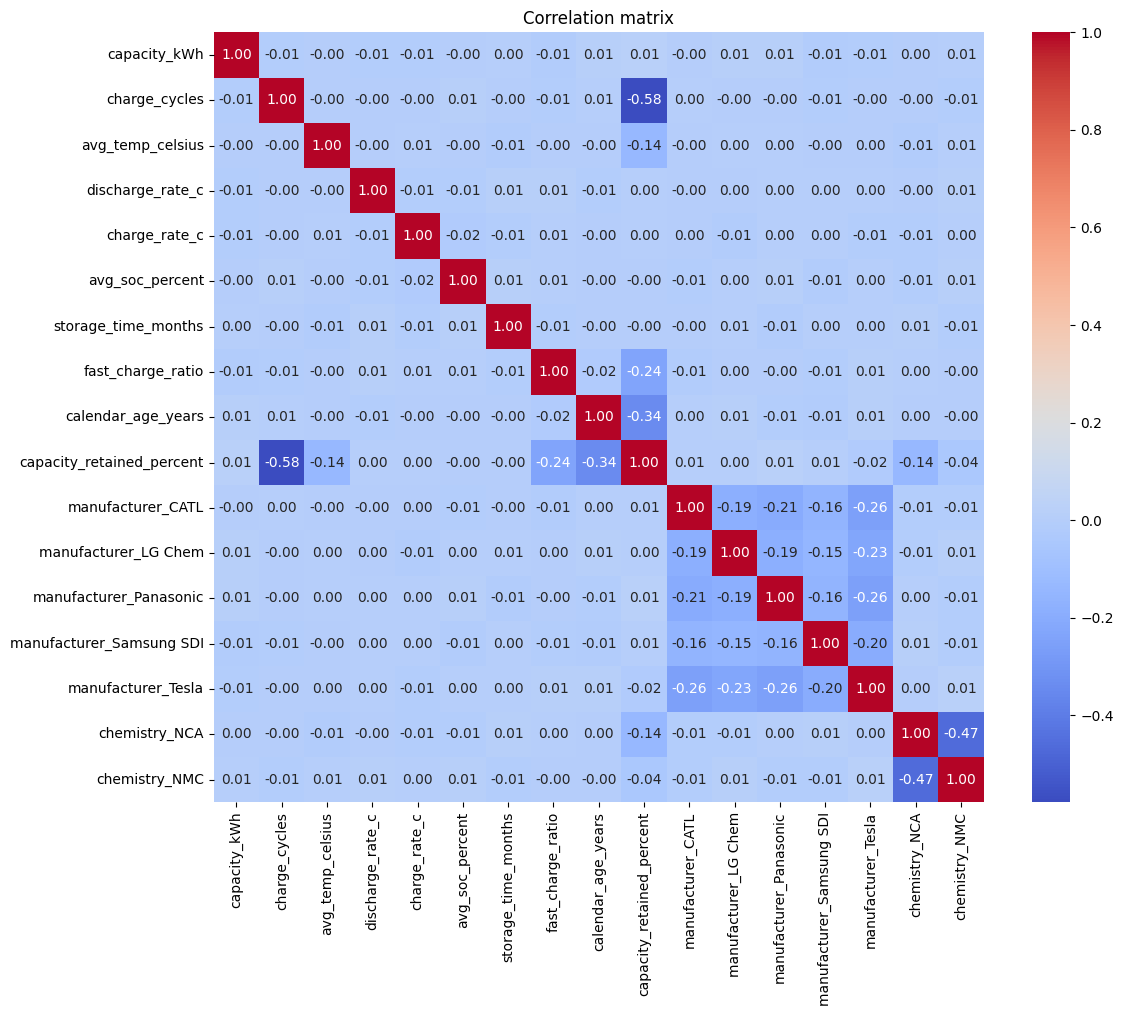

In [28]:
plt.figure(figsize=(12, 10))
corr_matrix = df_onehot.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

#### Боксплот

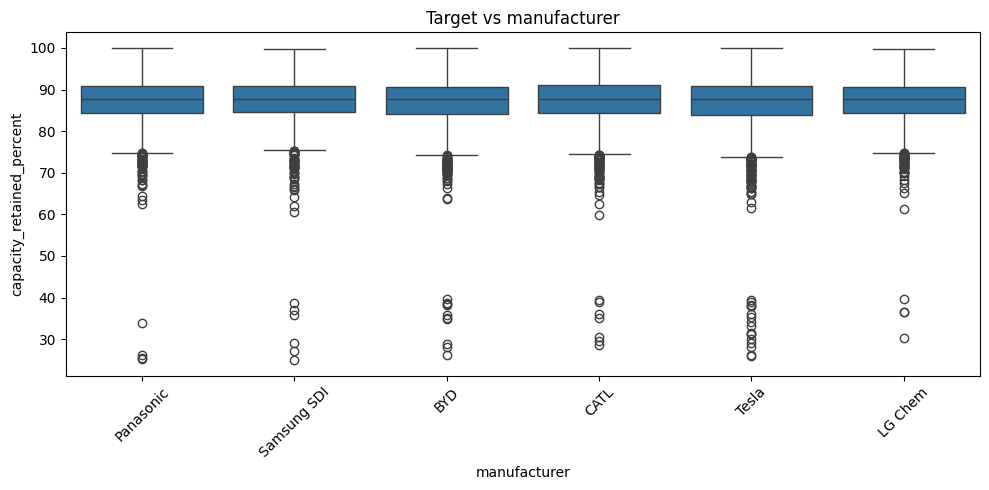

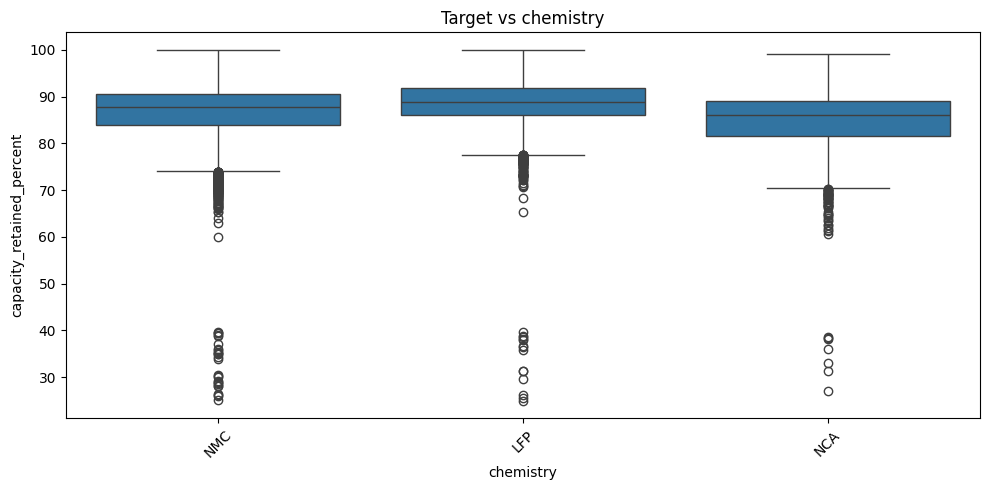

In [29]:
for col in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[col], y=df[TARGET_NAME])
    plt.title(f"Target vs {col}")
    plt.xlabel(col)
    plt.ylabel(TARGET_NAME)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Проверим коллинеарность фичей

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant

In [31]:
X_for_vif = df_onehot.drop(columns=[TARGET_NAME])

X_vif_ready = X_for_vif.select_dtypes(include=['int64', 'float64']).astype(float)

X_vif_ready = add_constant(X_vif_ready)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif_ready.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_ready.values, i) for i in range(X_vif_ready.shape[1])]
vif_data = vif_data[vif_data["Feature"] != "const"]

print("\n VIF Scores (Multicollinearity Check):")
print(vif_data.sort_values(by="VIF", ascending=False))


 VIF Scores (Multicollinearity Check):
                     Feature       VIF
14        manufacturer_Tesla  1.914566
12    manufacturer_Panasonic  1.730087
10         manufacturer_CATL  1.729971
11      manufacturer_LG Chem  1.648033
13  manufacturer_Samsung SDI  1.520014
16             chemistry_NMC  1.278729
15             chemistry_NCA  1.278371
8          fast_charge_ratio  1.001468
6            avg_soc_percent  1.001279
5              charge_rate_c  1.001227
9         calendar_age_years  1.001140
7        storage_time_months  1.000841
1               capacity_kWh  1.000810
4           discharge_rate_c  1.000575
2              charge_cycles  1.000516
3           avg_temp_celsius  1.000455


Выводы: значительной коллинеарности между фичами нет.

### Выберем лучшие фичи

Из фичей оставляем charge_cycles, avg_temp_celsius, fast_charge_ratio, calendar_age_years, chemistry_NCA. Новых фичей на основе имеющихся особо не сделать.

In [32]:
df_onehot = df_onehot[['charge_cycles', 'avg_temp_celsius', 'fast_charge_ratio', 'calendar_age_years', 'chemistry_NCA', TARGET_NAME]]

### Произведём скалирование величин

In [33]:
transform_columns = ['charge_cycles', 'avg_temp_celsius', 'fast_charge_ratio', 'calendar_age_years']

In [34]:
for col in transform_columns:
    scaler = StandardScaler()
    df_onehot[col] = scaler.fit_transform(df_onehot[[col]])

In [35]:
df_onehot.describe()

,charge_cycles,avg_temp_celsius,fast_charge_ratio,calendar_age_years,chemistry_NCA,capacity_retained_percent
count,1.493100e+04,1.493100e+04,1.493100e+04,1.493100e+04,14931.000000,14931.000000
mean,1.189711e-17,1.717942e-16,-1.955884e-16,-5.710611e-18,0.141585,86.983633
std,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,0.348635,6.178565
min,-1.727577e+00,-4.125362e+00,-1.593705e+00,-9.678138e-01,0.000000,25.010000
25%,-6.256801e-01,-5.433780e-01,-7.868459e-01,-7.036013e-01,0.000000,84.220000
50%,-1.736200e-01,2.101279e-02,-1.612380e-01,-3.046923e-01,0.000000,87.840000
75%,3.683384e-01,5.854035e-01,6.339272e-01,3.687905e-01,0.000000,90.810000
max,5.587577e+00,2.981693e+00,3.890597e+00,5.197144e+00,1.000000,99.990000


### Сохранение датасета

In [36]:
df_onehot.drop(columns=[TARGET_NAME]).to_csv('regression_processed_feats.csv', index=False)

In [37]:
df_onehot[TARGET_NAME].to_csv('regression_processed_target.csv', index=False)

# Выбор и обоснование метрик регрессии

Сделаем выбор в пользу MAE, RMSE и R2. 
MAE и RMSE удобны тем, что имеют ту же размерность, что исследуемая величина, но при этом MAE менее чувствителен к выбросам, а RMSE более чувствителен. 
R2 позволяет сравнить нашу модель с наивной моделью, предсказывающей среднее значение.

# Датасет классификации

## Описание датасета

🧍‍♀️ 6 000 unique users performing ≈300 000 transactions

💳 Multiple transactions per user (40–60) → enables behavioral analysis

🧩 Strong feature correlations — not random noise

🌐 Cross-country dynamics (country, bin_country)

💸 Natural imbalance (~2 % fraud) just like real financial systems

🕓 Time realism — night-time fraud spikes, daily rhythms

🧠 Feature explainability — easy to visualize, model, and interpret

## Обоснование выбора

В 2024 году электронные коммерческие площадки в Стамбуле, Берлине, Нью-Йорке, Лондоне и Париже начали замечать странные всплески транзакций. Некоторые карты тестировались покупками на 1 доллар в полночь, другие отправляли «игровые аксессуары» на расстояние в 5000 км. Промокоды использовались повторно с только что созданных аккаунтов.

Данный датасет рассматривает данную актуальную проблему - мошеннические транзакции и их определение. Для этого в датасете имеется значительное количество различных данных для наблюдения и создания новых фич, к примеру для отслеживания использования виртуальных карт.

## Анализ и обработка датасета

#### Загрузим датасет через kagglehub

In [38]:
dataset_path = kagglehub.dataset_download('umuttuygurr/e-commerce-fraud-detection-dataset')

In [39]:
filename = os.listdir(dataset_path)[0]

In [40]:
df = pd.read_csv(os.path.join(dataset_path,filename))

### Рассмотрим датасет

In [41]:
len(df)

299695

In [42]:
df.head()

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           299695 non-null  int64  
 1   user_id                  299695 non-null  int64  
 2   account_age_days         299695 non-null  int64  
 3   total_transactions_user  299695 non-null  int64  
 4   avg_amount_user          299695 non-null  float64
 5   amount                   299695 non-null  float64
 6   country                  299695 non-null  object 
 7   bin_country              299695 non-null  object 
 8   channel                  299695 non-null  object 
 9   merchant_category        299695 non-null  object 
 10  promo_used               299695 non-null  int64  
 11  avs_match                299695 non-null  int64  
 12  cvv_result               299695 non-null  int64  
 13  three_ds_flag            299695 non-null  int64  
 14  tran

In [44]:
df.isnull().sum()

transaction_id             0
user_id                    0
account_age_days           0
total_transactions_user    0
avg_amount_user            0
amount                     0
country                    0
bin_country                0
channel                    0
merchant_category          0
promo_used                 0
avs_match                  0
cvv_result                 0
three_ds_flag              0
transaction_time           0
shipping_distance_km       0
is_fraud                   0
dtype: int64

Пустые строки отсуствуют!

In [45]:
df.describe(include='all')

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
count,299695.0000,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000,299695,299695,299695,299695,299695.000000,299695.000000,299695.000000,299695.000000,299695,299695.000000,299695.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,10,10,2,5,NaN,NaN,NaN,NaN,297975,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,US,US,web,electronics,NaN,NaN,NaN,NaN,2024-10-17T01:27:59Z,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,32430,32295,152226,60220,NaN,NaN,NaN,NaN,3,NaN,NaN
mean,149848.0000,3002.559432,973.397871,50.673321,148.142973,177.165279,NaN,NaN,NaN,NaN,0.153640,0.837999,0.872110,0.784588,NaN,357.049028,0.022062
std,86514.6388,1732.309663,525.241409,5.976391,200.364624,306.926507,NaN,NaN,NaN,NaN,0.360603,0.368453,0.333968,0.411109,NaN,427.672074,0.146887
min,1.0000,1.000000,1.000000,40.000000,3.520000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
25%,74924.5000,1501.000000,516.000000,46.000000,46.190000,42.100000,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000,1.000000,NaN,136.600000,0.000000
50%,149848.0000,3007.000000,975.000000,51.000000,90.130000,89.990000,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000,1.000000,NaN,273.020000,0.000000
75%,224771.5000,4504.000000,1425.000000,56.000000,173.450000,191.110000,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000,1.000000,NaN,409.180000,0.000000


In [46]:
set(df['country'].unique().tolist()) | set(df['bin_country'].unique().tolist())

{'DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PL', 'RO', 'TR', 'US'}

In [47]:
TARGET_NAME = "is_fraud"

### Сохраним необработанный датасет

Категориальные переменные отбрасываем

In [48]:
df[df.select_dtypes(include=["int64", "float64"]).columns.to_list()].drop(columns=TARGET_NAME).to_csv("classification_raw_feats.csv", index=False)

In [49]:
df[[TARGET_NAME]].to_csv('classification_raw_target.csv', index=False)

### Преобразуем данные

#### Преобразуем даты

In [50]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'])

#### Создадим новые фичи

##### Время

###### Рассмотрим совпадение страны карты и страны транзакции

In [51]:
df['bin_country_match'] = (df['country'] == df['bin_country']).astype(int)

###### Выберем обычную страну клиента и сравним, из неё ли делалась транзакция

In [52]:
usual_countries = df.groupby('user_id')['country'].agg(pd.Series.mode)

usual_countries = usual_countries.rename('usual_country')

df = df.merge(usual_countries.to_frame(), on='user_id', how='left')

In [53]:
df['usual_country_match'] = (df['country'] == df['usual_country']).astype(int)

###### Посчитаем время суток в стране, из которой карта

In [54]:
COUNTRY_TZ_MAP = {
    'DE': 'Europe/Berlin',
    'ES': 'Europe/Madrid',
    'FR': 'Europe/Paris',
    'GB': 'Europe/London',
    'IT': 'Europe/Rome',
    'NL': 'Europe/Amsterdam',
    'PL': 'Europe/Warsaw',
    'RO': 'Europe/Bucharest',
    'TR': 'Europe/Istanbul',
    'US': 'America/New_York',
}

In [55]:
df['bin_transaction_time'] = df.apply(
    lambda row: row['transaction_time'].tz_convert(COUNTRY_TZ_MAP.get(row['country'])),
    axis=1
)

In [56]:
df['bin_transaction_hour_minute'] = df.apply(
    lambda row: row['bin_transaction_time'].hour + row['bin_transaction_time'].minute / 60,
    axis=1)

###### Посмотрим, ночь ли в стране, из которой карта

In [57]:
NIGHT_START_HOUR = 22.0
NIGHT_END_HOUR = 6.0

In [58]:
df['bin_night'] = df.apply(lambda row: int((row['bin_transaction_hour_minute'] >= NIGHT_START_HOUR) or (row['bin_transaction_hour_minute'] < NIGHT_END_HOUR)), axis = 1)

###### Посчитаем медианное время транзакции для заказа у клиента

In [59]:
usual_countries = df.groupby('user_id')['bin_transaction_hour_minute'].agg(pd.Series.median)

usual_countries = usual_countries.rename('bin_transaction_hour_minute_average')

df = df.merge(usual_countries.to_frame(), on='user_id', how='left')

###### Посчитаем отхождение времени транзакции от среднего времени

In [60]:
df['bin_transaction_time_difference'] = df.apply(
    lambda row: abs(row['bin_transaction_hour_minute_average'] - row['bin_transaction_hour_minute']),
    axis=1)

##### Стоимость

###### Разница со средней транзакцией по стоимости

In [61]:
df['amount_difference'] = df.apply(
    lambda row: abs(row['avg_amount_user'] - row['amount']),
    axis=1)

##### Расстояние

###### Посчитаем медианное расстояние для заказа у клиента

In [62]:
usual_countries = df.groupby('user_id')['shipping_distance_km'].agg(pd.Series.median)

usual_countries = usual_countries.rename('average_shipping_distance_km')

df = df.merge(usual_countries.to_frame(), on='user_id', how='left')

###### Посчитаем отхождение времени транзакции от среднего времени

In [63]:
df['difference_shipping_distance_km'] = df.apply(
    lambda row: abs(row['average_shipping_distance_km'] - row['shipping_distance_km']),
    axis=1)

##### Логарифмируем часть столбцов

In [64]:
log_column_names = ['avg_amount_user', 'amount_difference', 'account_age_days', 'shipping_distance_km', 'average_shipping_distance_km', 'difference_shipping_distance_km']

In [65]:
for col in log_column_names:
    new_col_name = f'log_{col}'
    df[new_col_name] = np.log1p(df[col])

##### Уберём мещающие рассчитанные фичи

In [66]:
df.drop(columns=['bin_transaction_time', 'transaction_id', 'user_id'], inplace=True)

#### Уберём transaction time и сделаем one-hot encoding

In [67]:
df.drop(columns=['transaction_time'], inplace=True)

In [68]:
df_onehot = pd.get_dummies(df, drop_first=True, dtype=int)

### Рассмотрим распределения величин

#### Численные величины

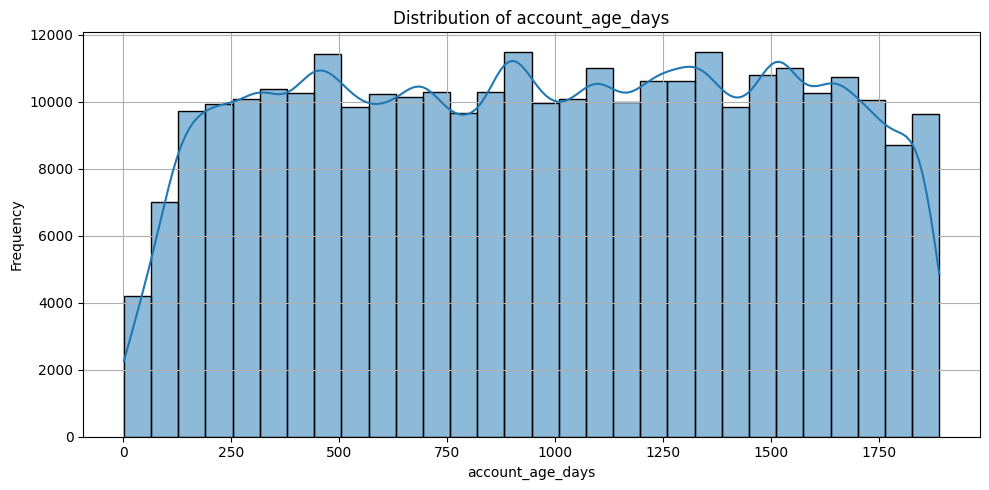

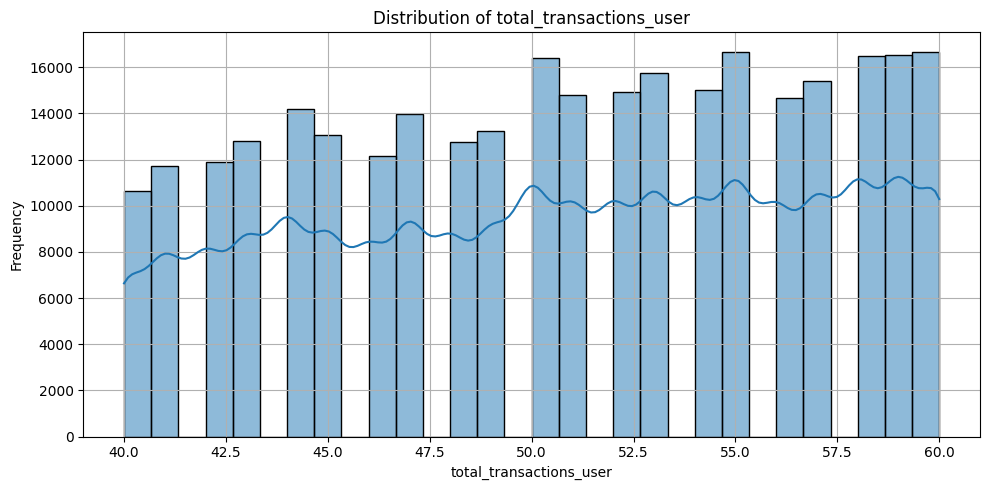

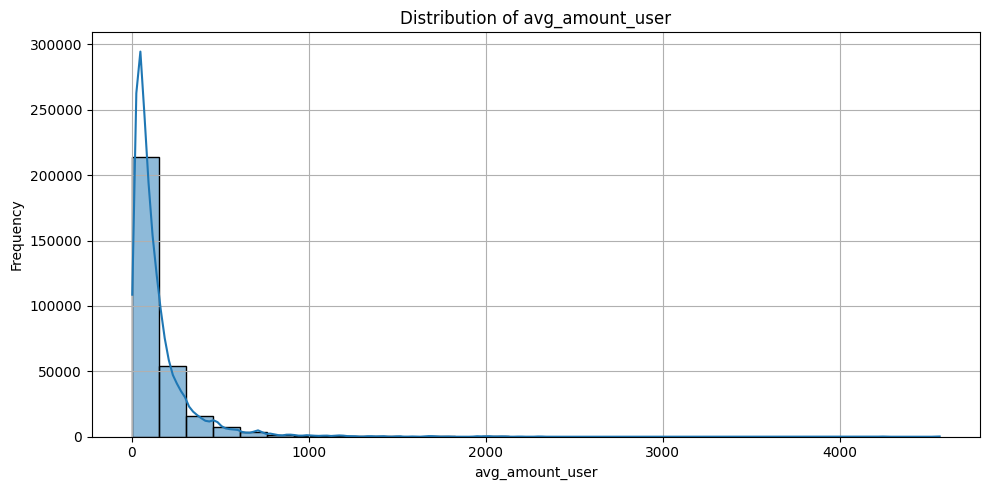

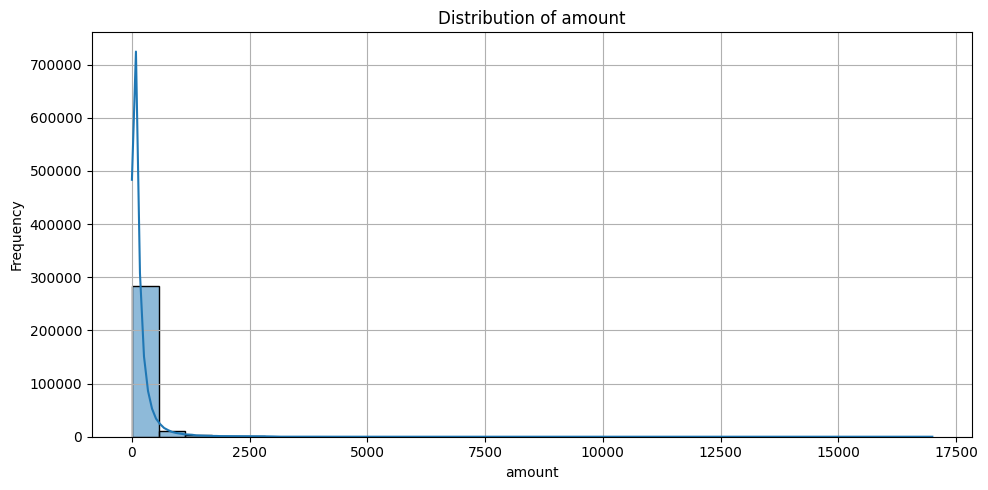

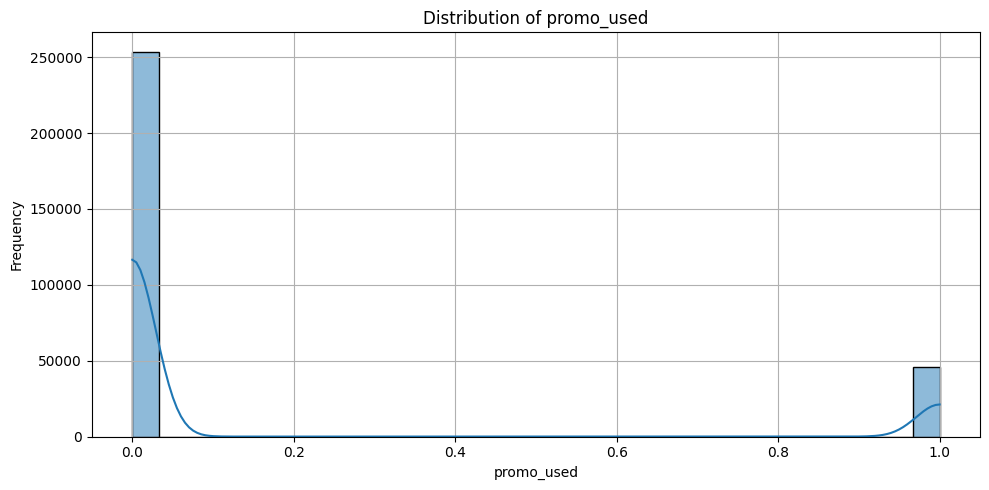

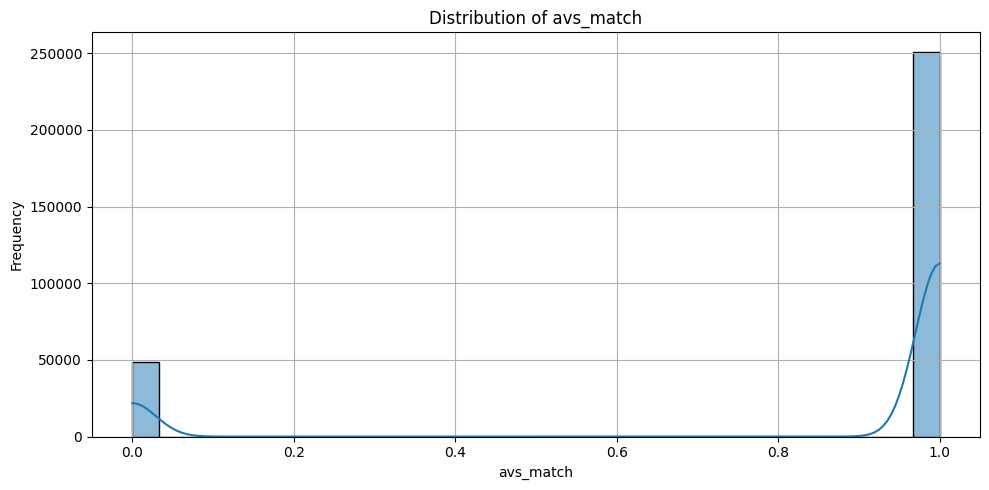

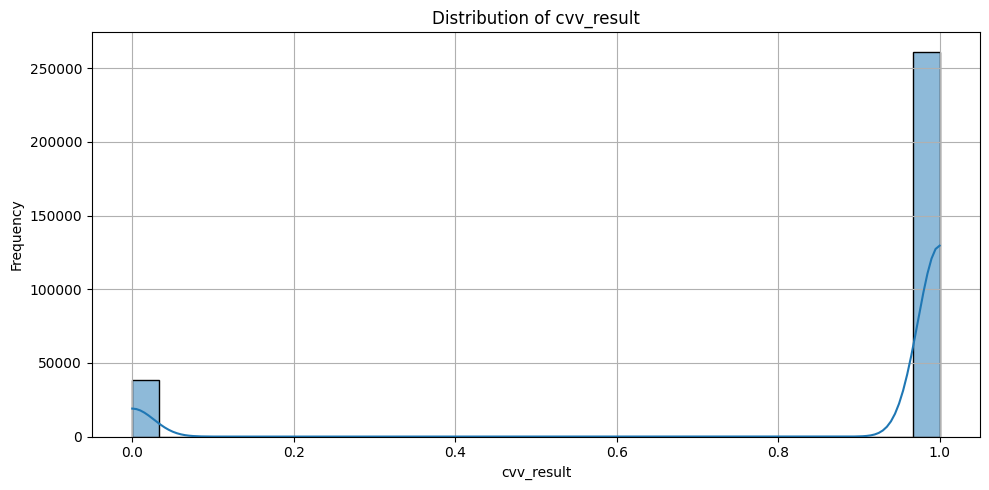

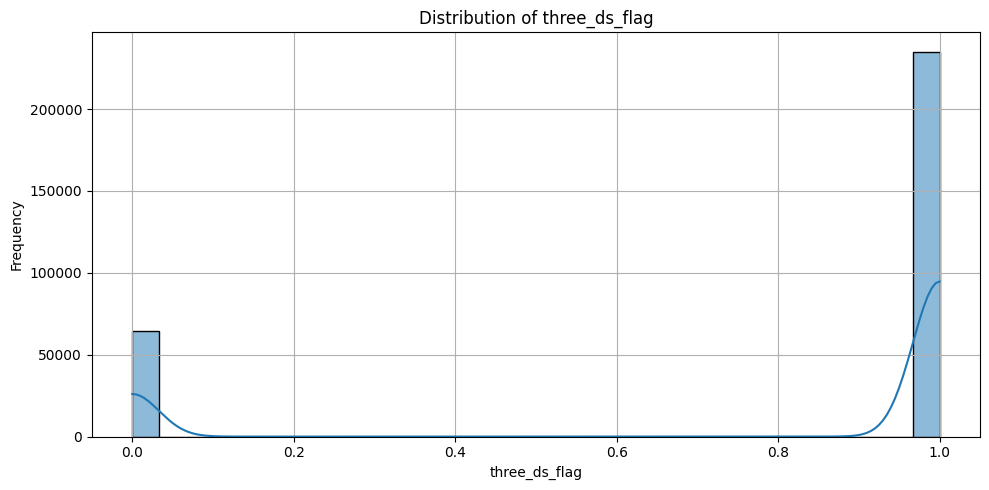

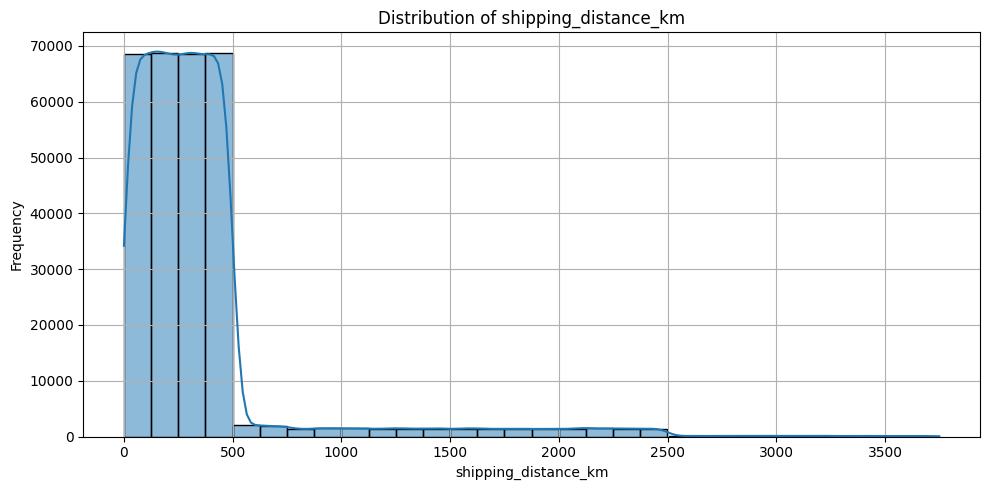

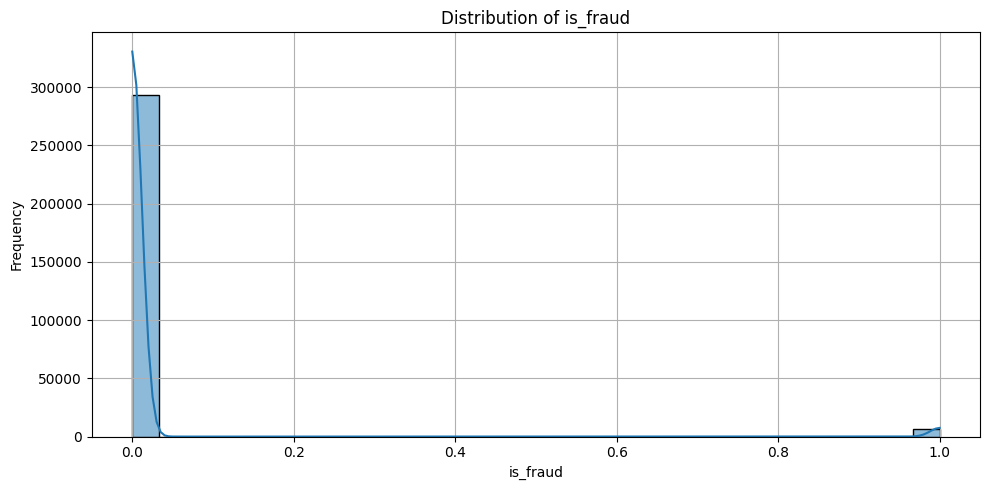

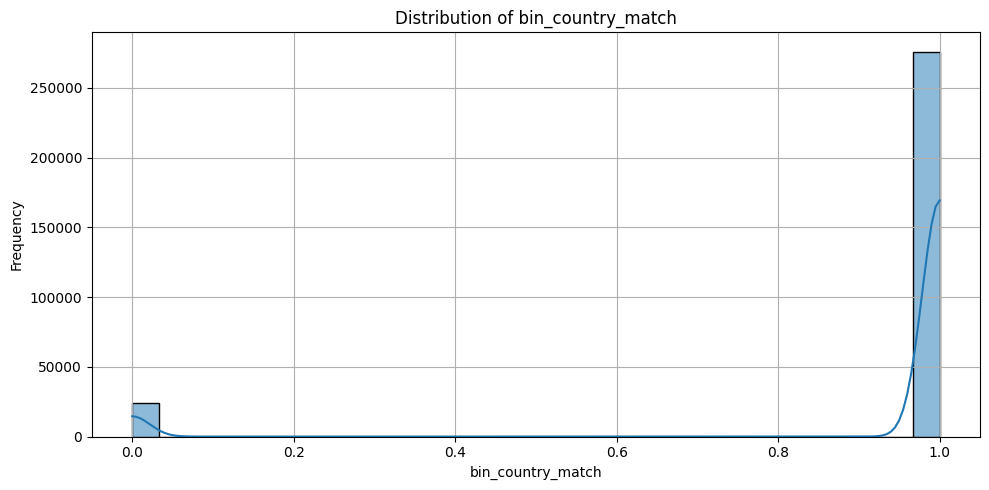

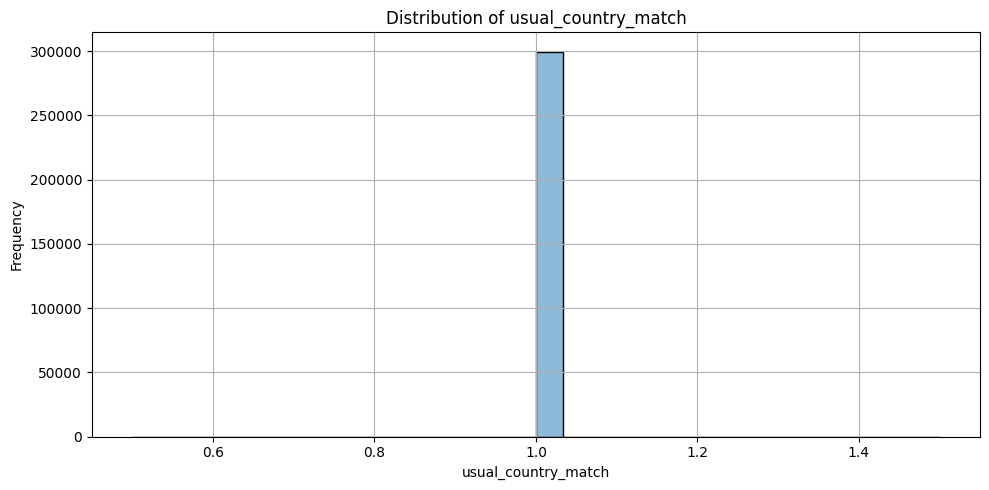

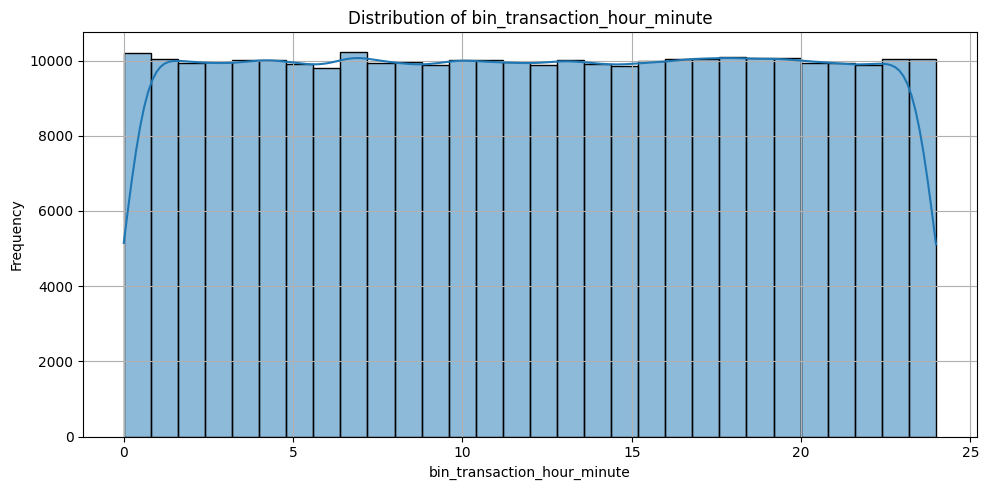

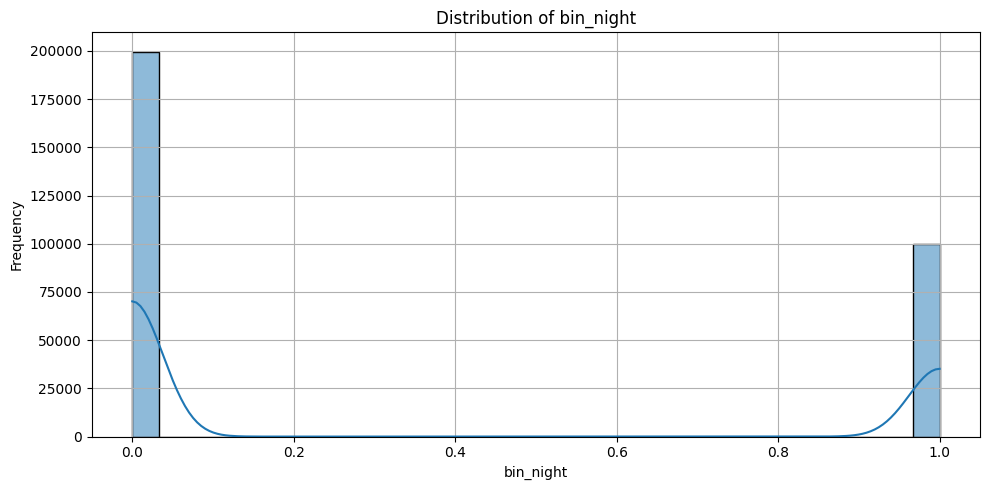

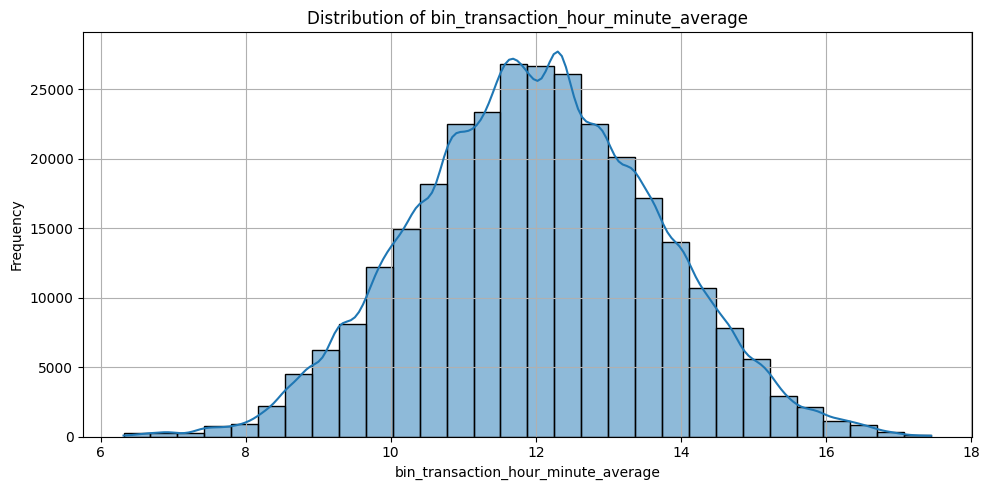

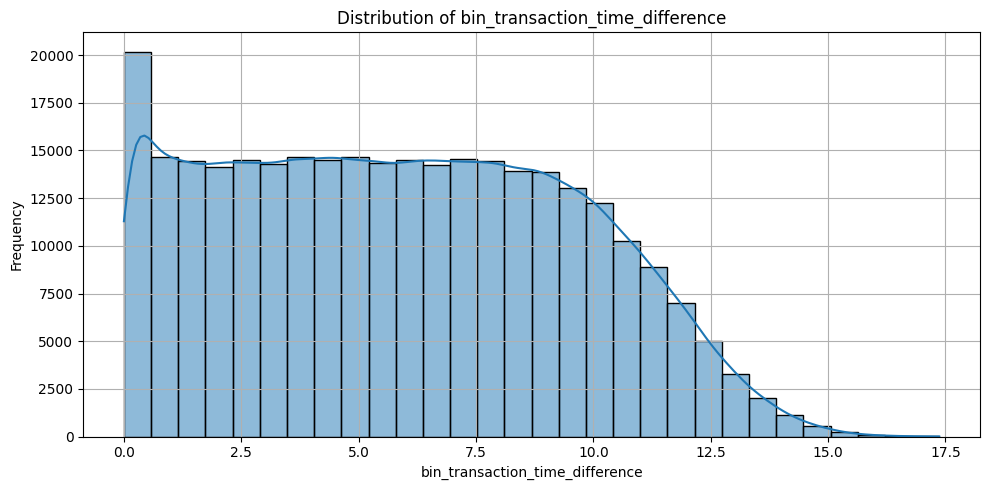

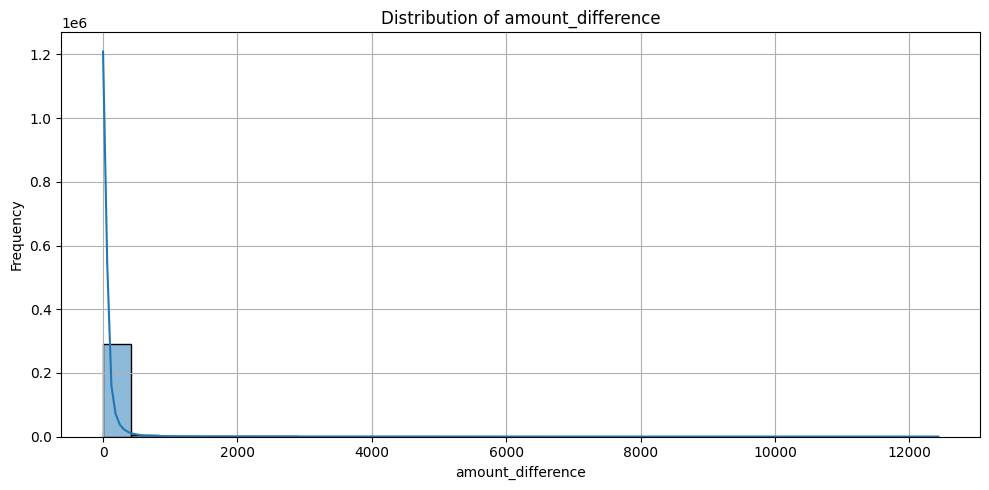

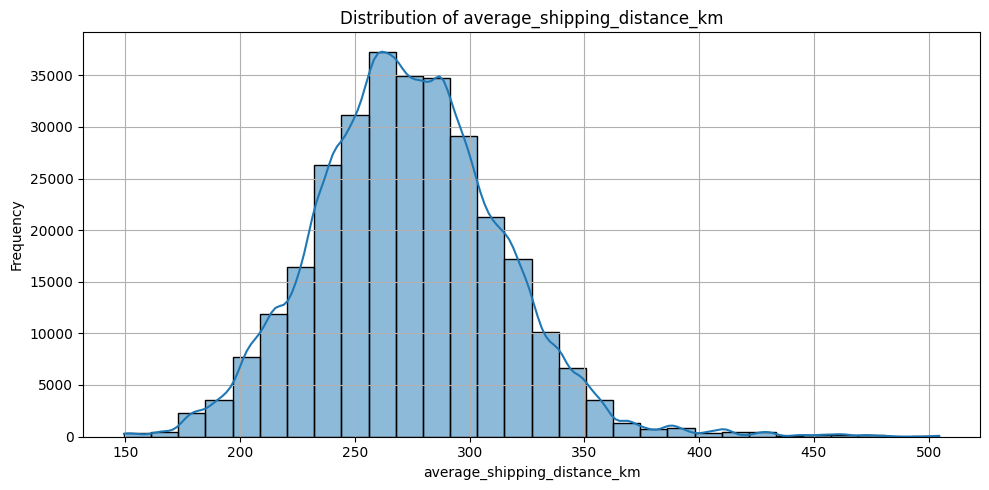

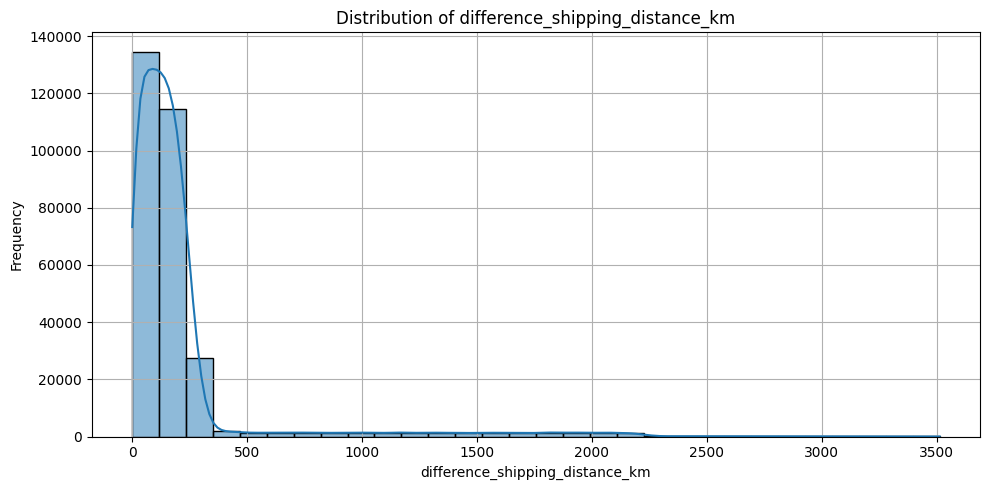

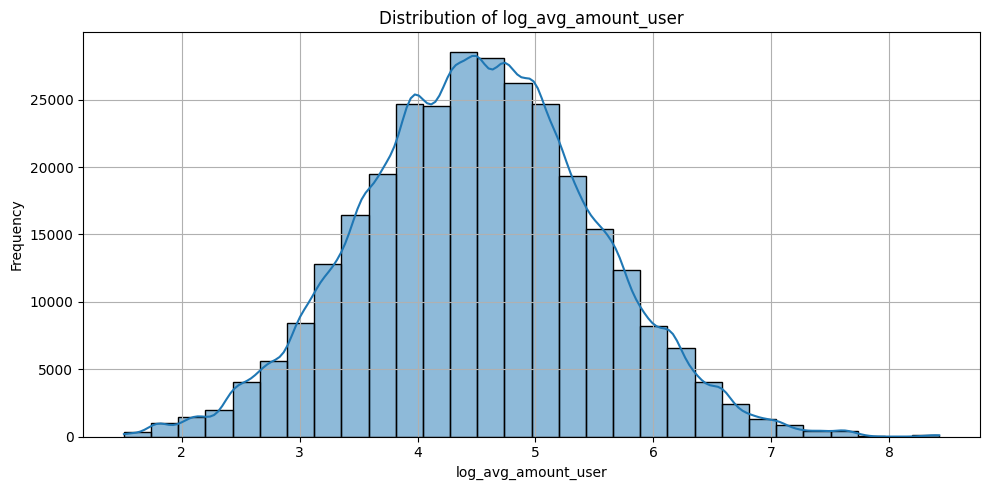

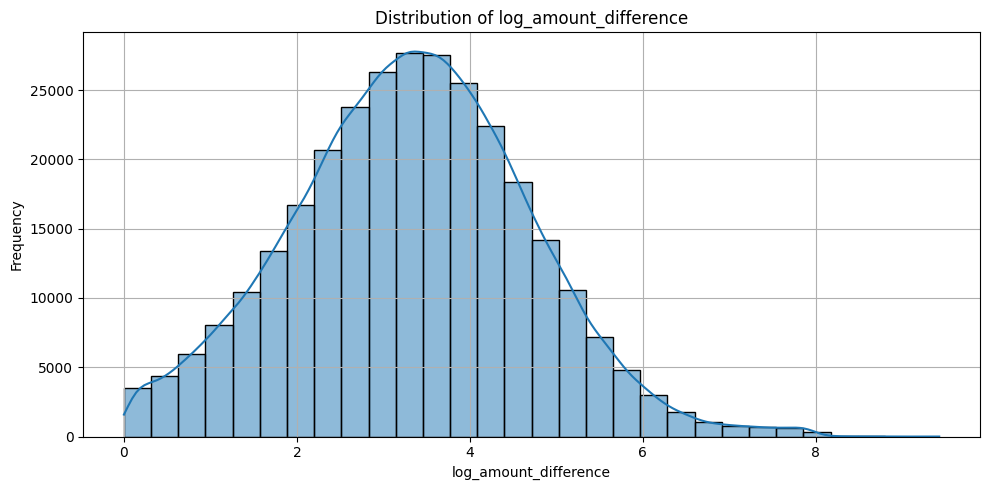

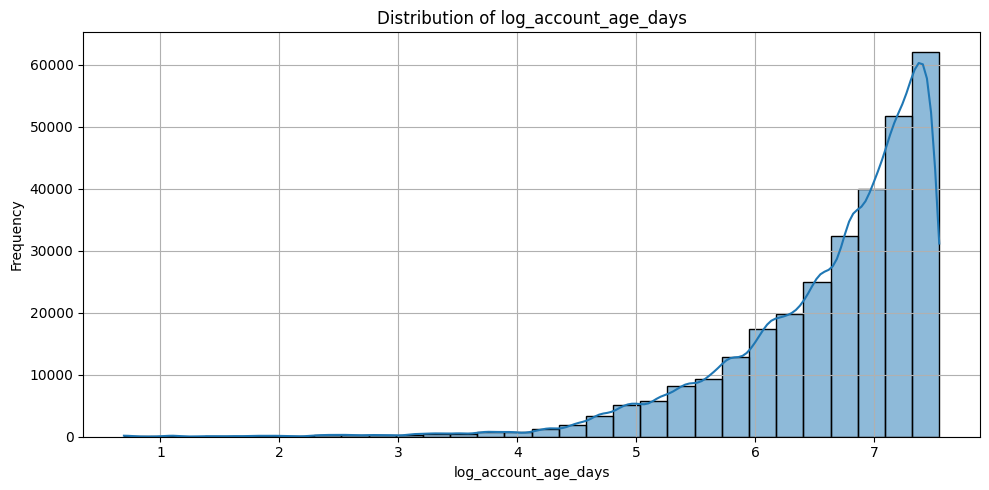

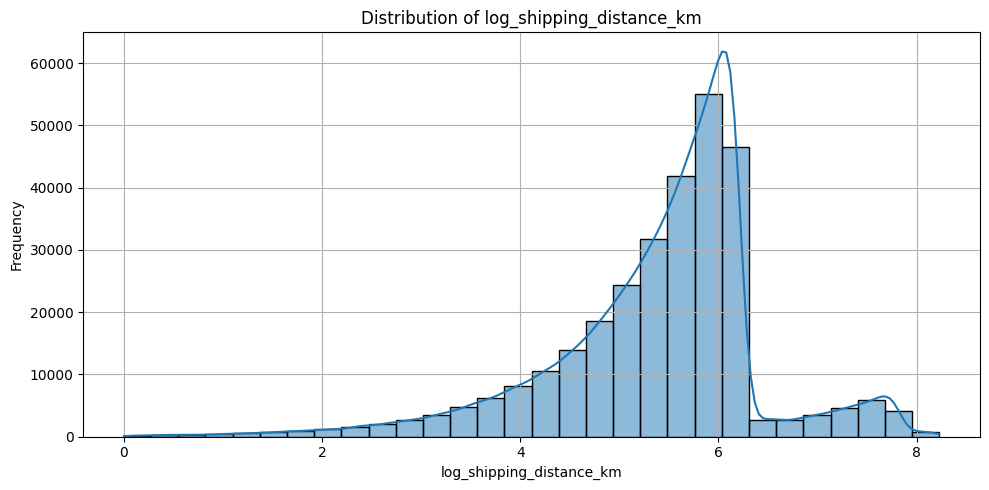

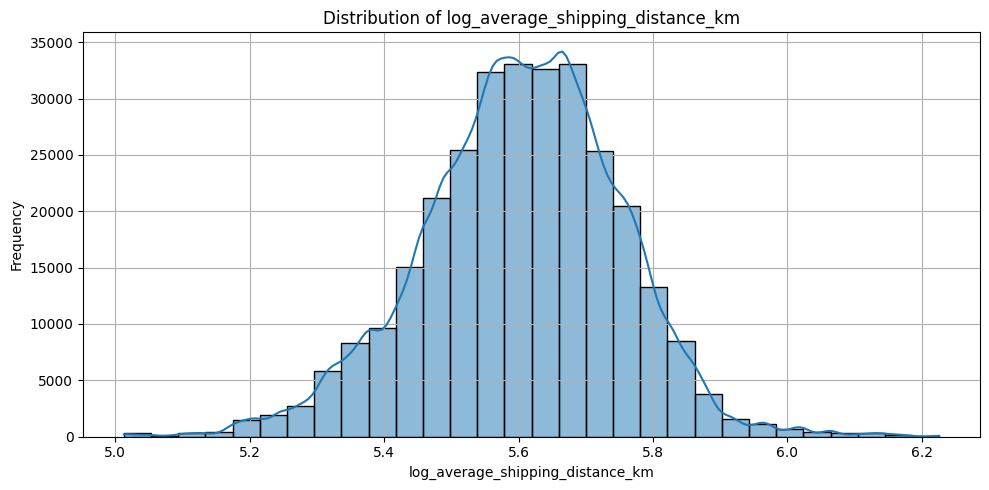

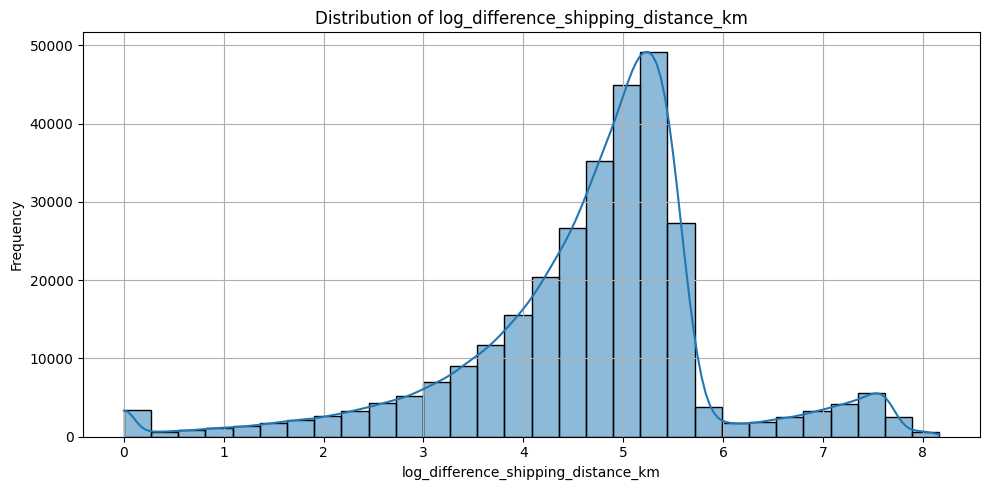

In [69]:
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.to_list()

for col in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Категориальные величины

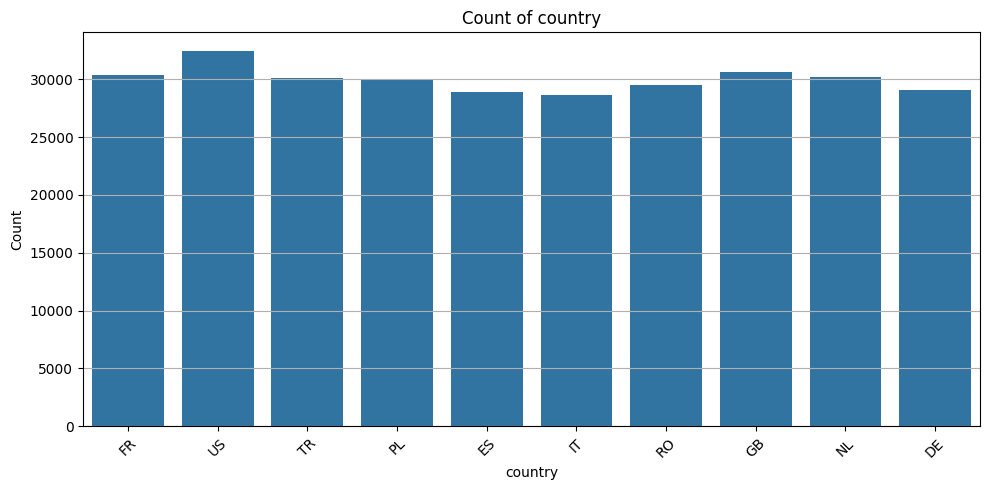

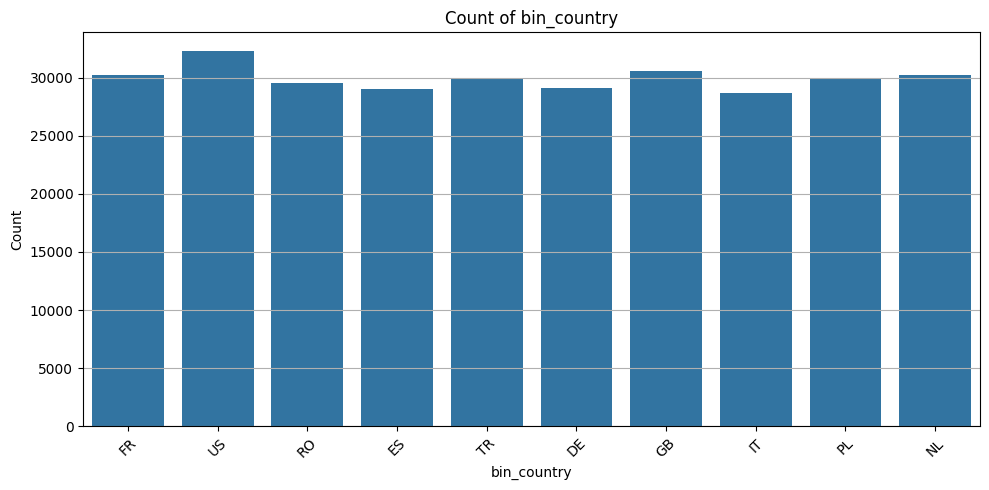

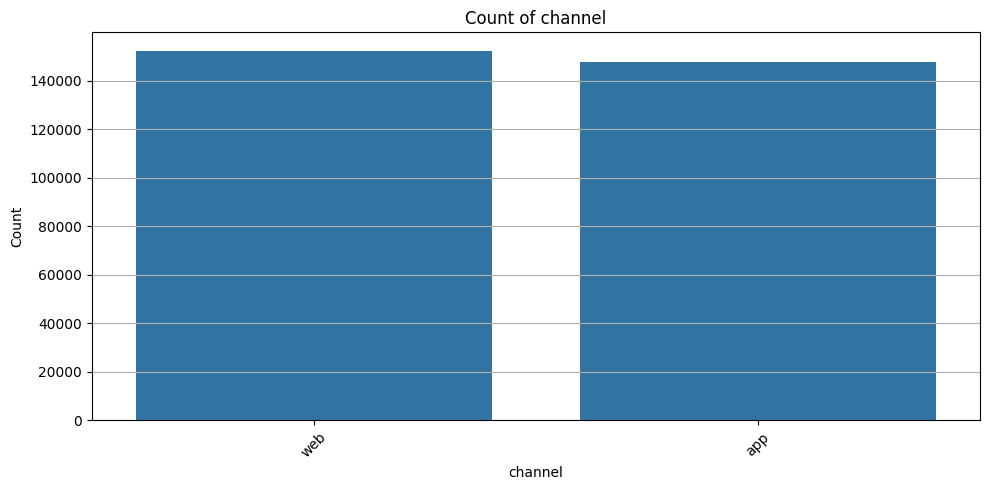

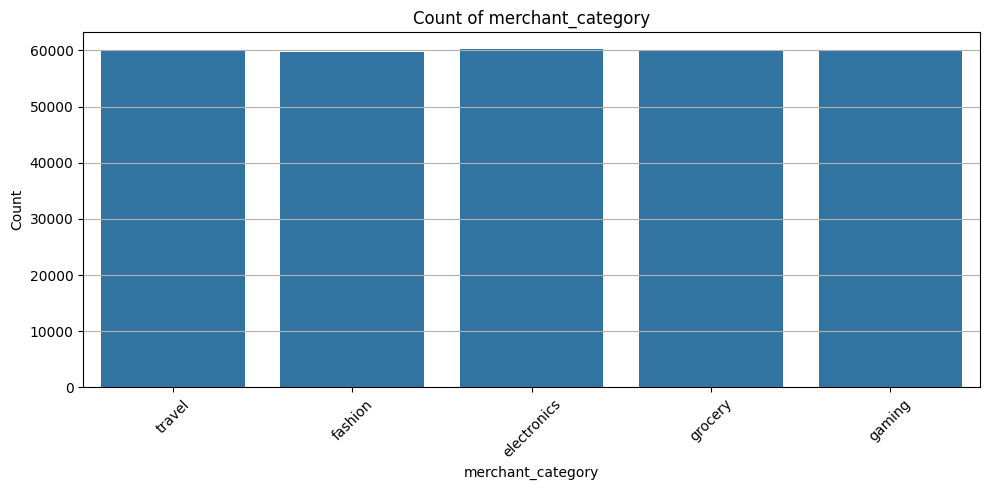

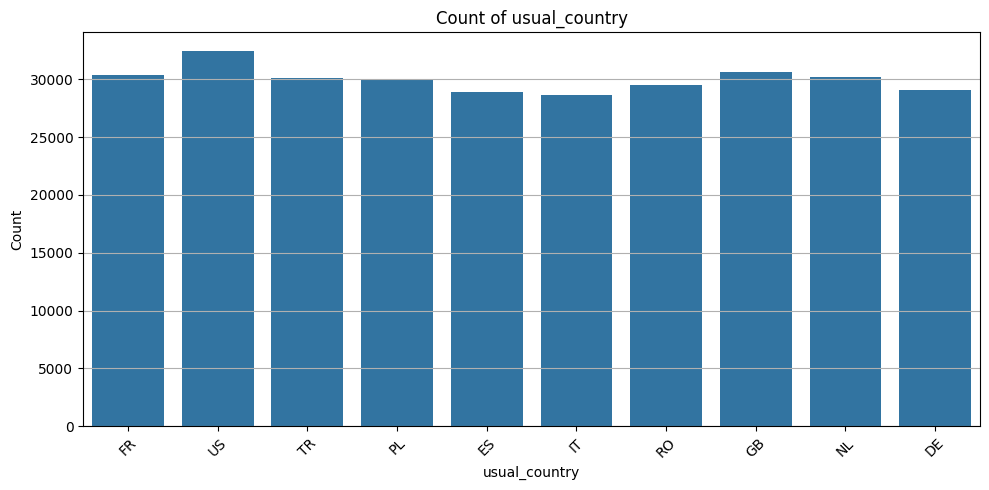

In [70]:
categorical_features = df.select_dtypes(include=["object"]).columns.to_list()

for col in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=df[col])
    plt.title(f"Count of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

#### Матрица корреляции

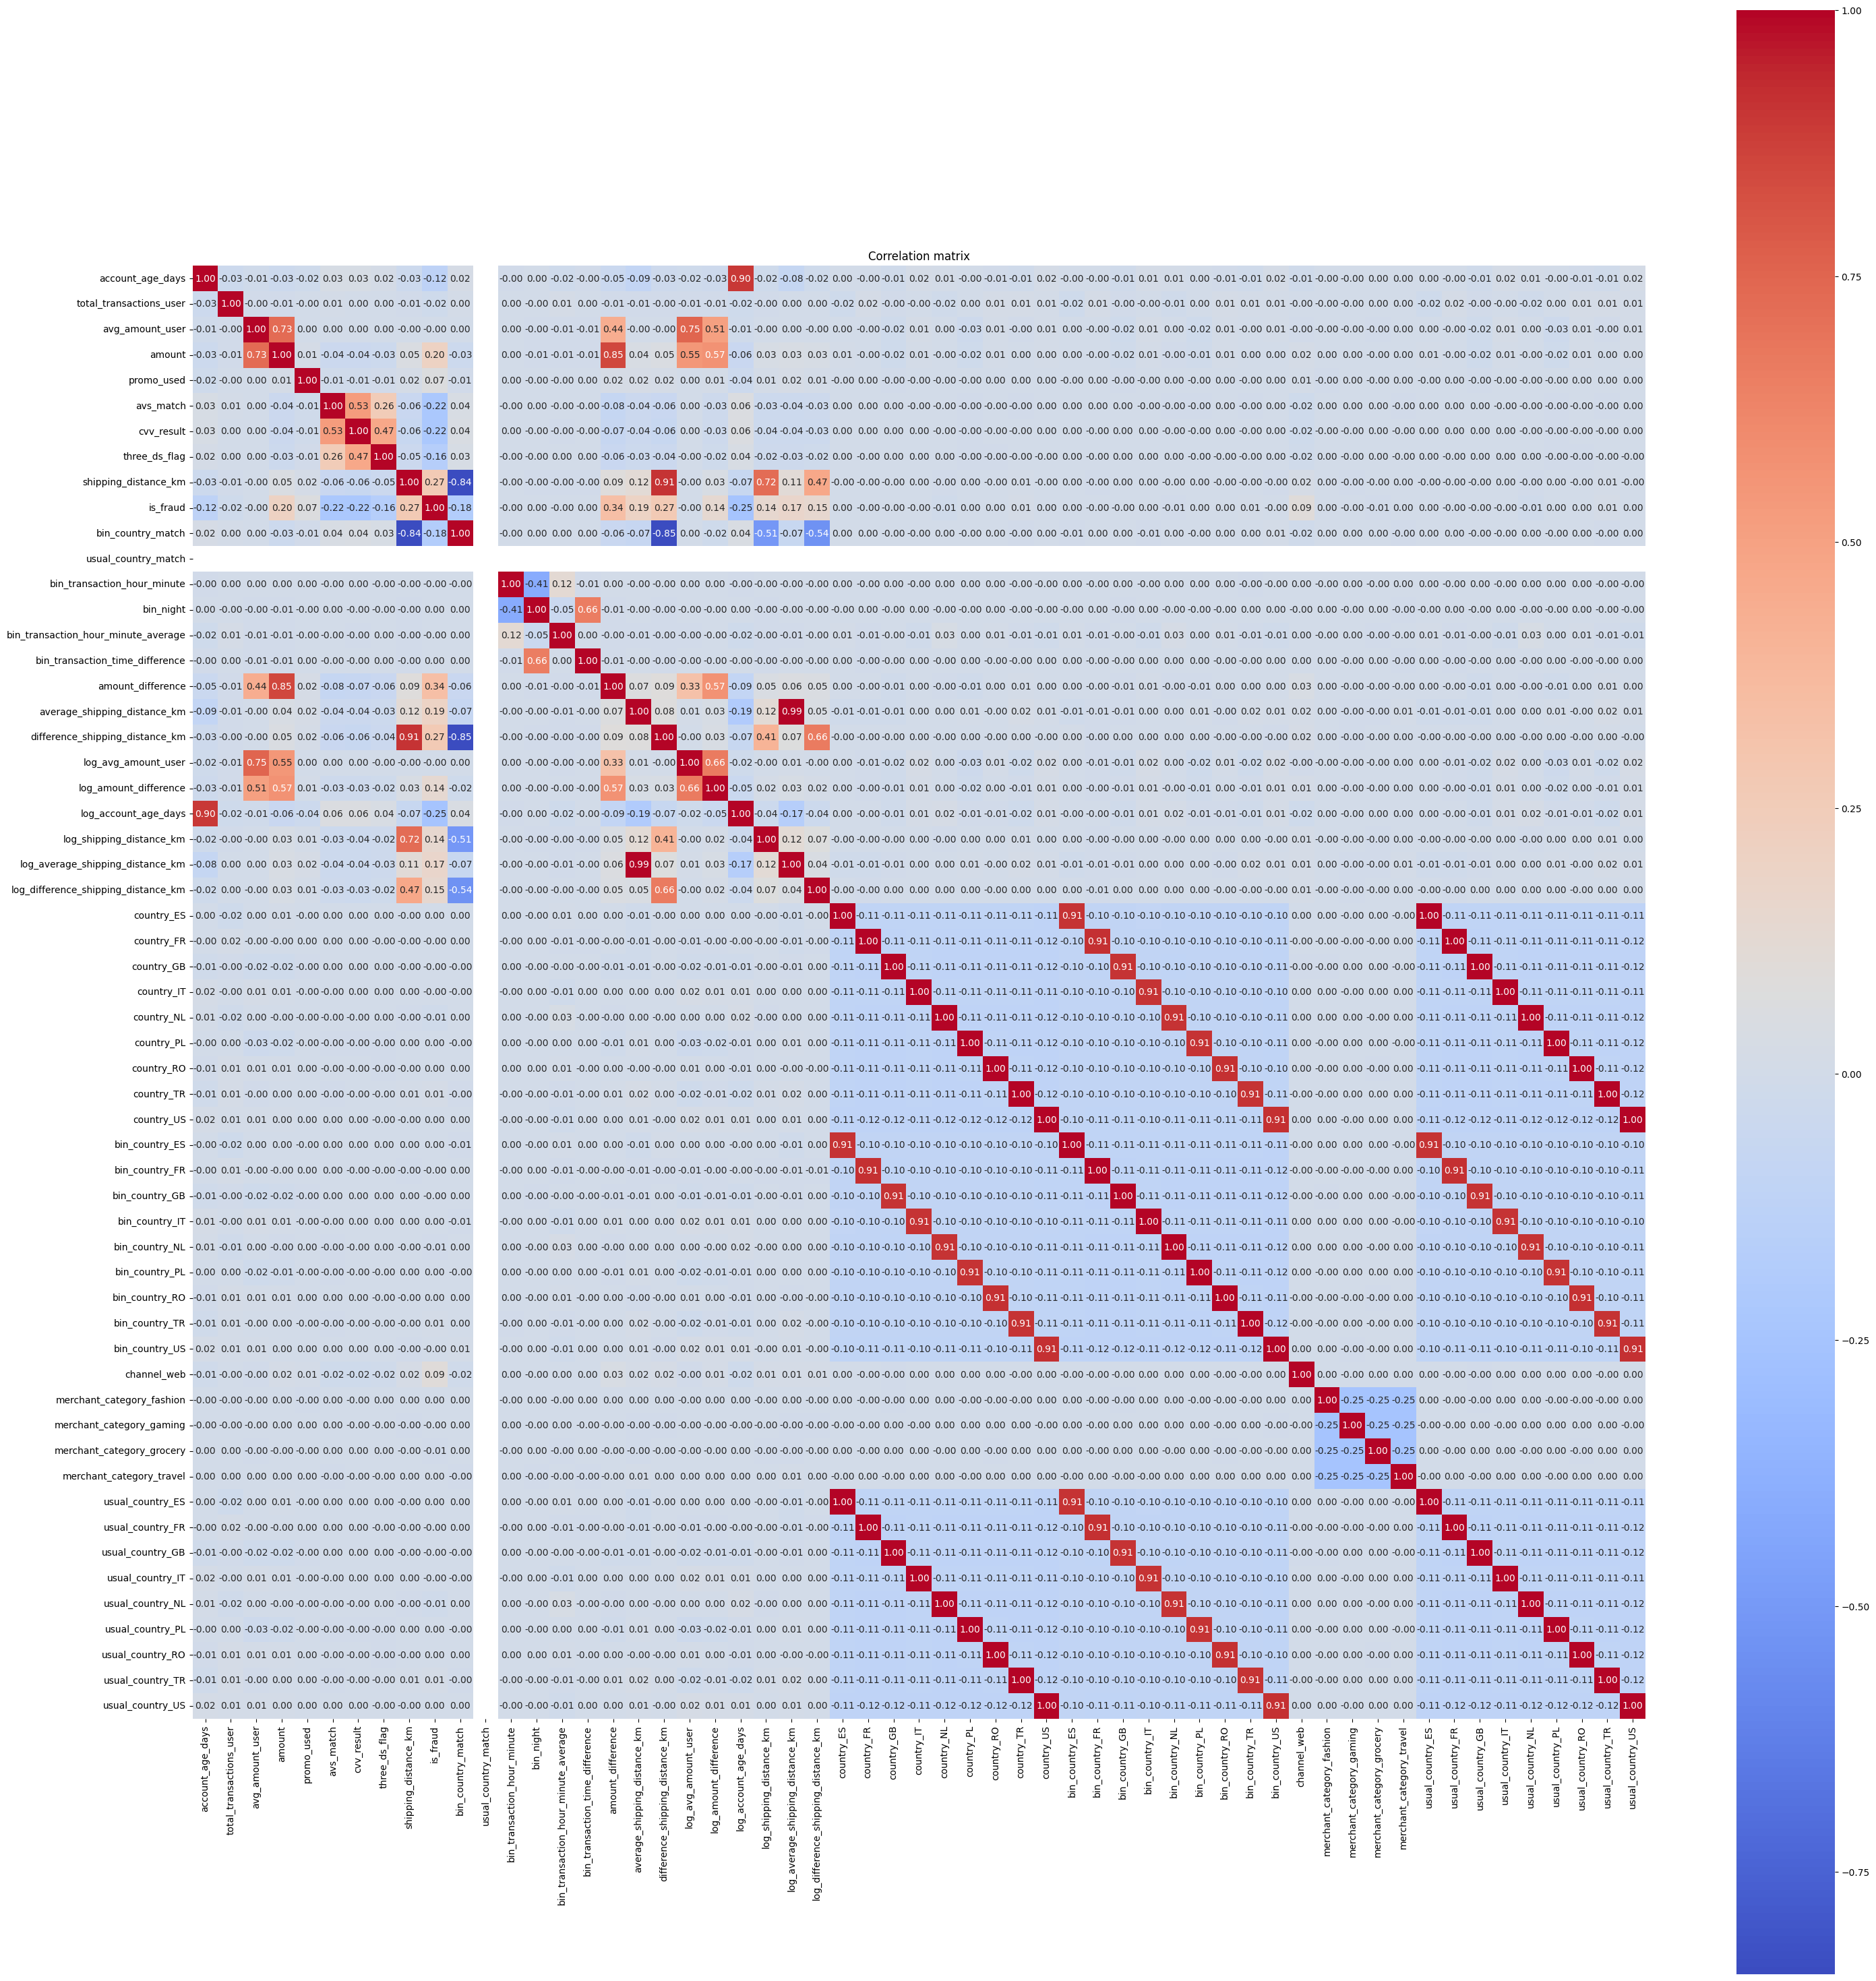

In [71]:
plt.figure(figsize=(30, 30))
corr_matrix = df_onehot.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

Удалим страны и категории, т.к. для них корреляции нет, и посмотрим ещё

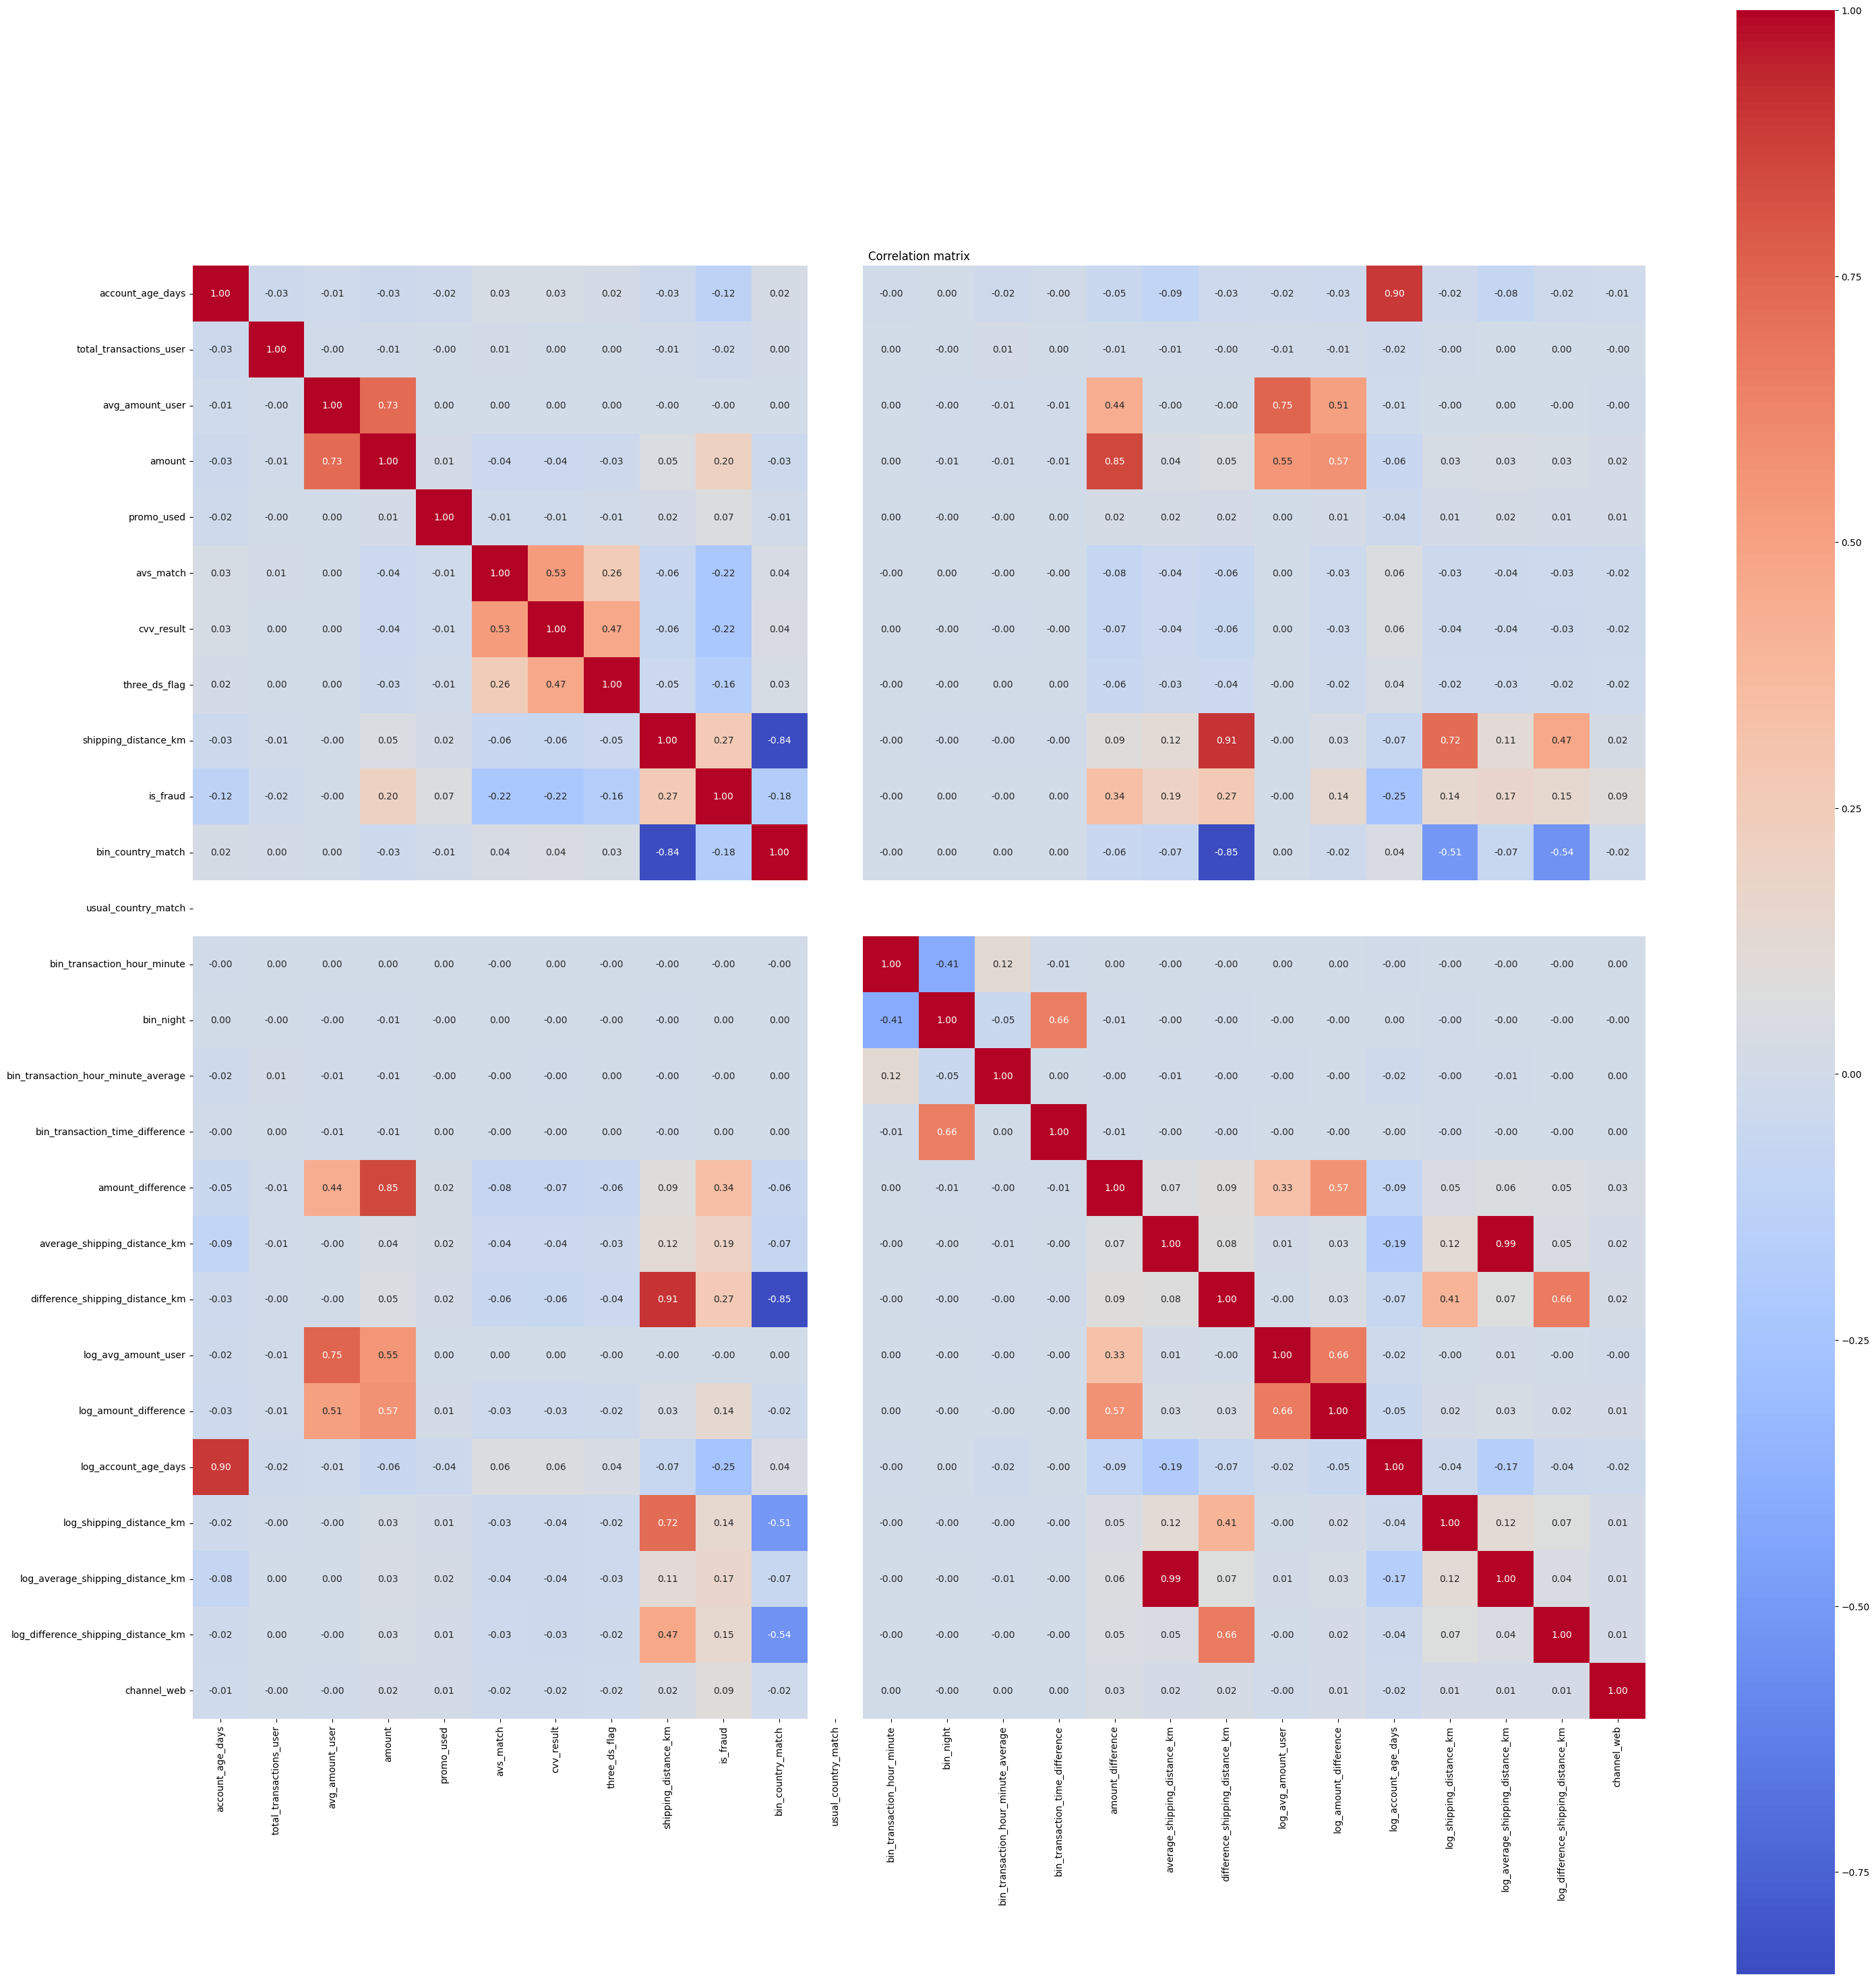

In [72]:
plt.figure(figsize=(30, 30))
corr_matrix = pd.get_dummies(df.drop(columns=['usual_country', 'bin_country', 'country', 'merchant_category']), drop_first=True).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

### Проверим коллинеарность фичей

In [73]:
X_for_vif = df_onehot.drop(columns=[TARGET_NAME])

X_vif_ready = X_for_vif.select_dtypes(include=['int64', 'float64']).astype(float)

X_vif_ready = add_constant(X_vif_ready)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif_ready.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_ready.values, i) for i in range(X_vif_ready.shape[1])]
vif_data = vif_data[vif_data["Feature"] != "const"]

print("\n VIF scores:")
print(vif_data.sort_values(by="VIF", ascending=False))

h:\PYTHON\ML_clean_env\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



 VIF scores:
                                Feature           VIF
31                           country_TR           inf
30                           country_RO           inf
29                           country_PL           inf
28                           country_NL           inf
27                           country_IT           inf
26                           country_GB           inf
48                     usual_country_FR           inf
55                     usual_country_US           inf
47                     usual_country_ES           inf
54                     usual_country_TR           inf
53                     usual_country_RO           inf
52                     usual_country_PL           inf
51                     usual_country_NL           inf
50                     usual_country_IT           inf
49                     usual_country_GB           inf
32                           country_US           inf
25                           country_FR           inf
24            

Выводы: нужно отбирать одну из нескольких фичей одного типа.

### Выберем лучшие фичи

Посмотрим, что скажет подбор через модель

In [74]:
n_features = 20

In [75]:
X = df_onehot.drop(columns=[TARGET_NAME])
y = df_onehot[TARGET_NAME]

In [76]:
model = RandomForestClassifier(n_estimators=100, max_depth = 30, random_state=42, n_jobs=-1)
model.fit(X, y)

RandomForestClassifier(max_depth=30, n_jobs=-1, random_state=42)

In [77]:
importances = model.feature_importances_
indices = np.argsort(importances)[-n_features:]

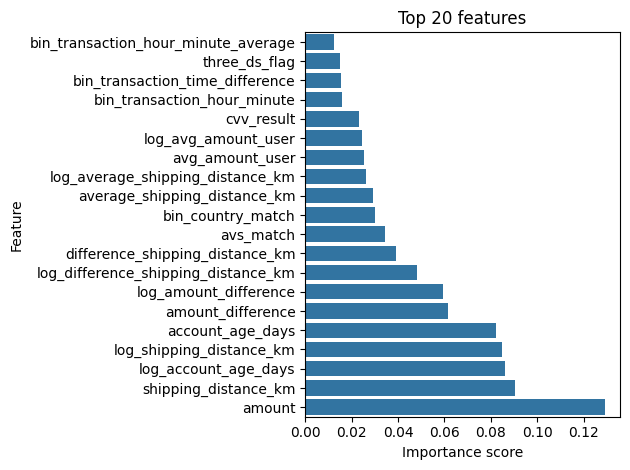

In [78]:
plt.title(f"Top {n_features} features")
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.xlabel("Importance score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

На основе анализа и пробного обучения оставляем 'channel_web', 'shipping_distance_km', 'log_account_age_days', 'amount_difference', 'bin_country_match', 'cvv_result', 'three_ds_flag', 'avs_match', 'promo_used'.

In [79]:
df_onehot = df_onehot[['channel_web', 'shipping_distance_km', 'log_difference_shipping_distance_km', 'log_account_age_days', 'amount', 'log_amount_difference', 'bin_country_match', 'cvv_result', 'three_ds_flag', 'avs_match', 'promo_used', TARGET_NAME]]

### Проверим коллинеарность ещё раз

In [80]:
X_for_vif = df_onehot.drop(columns=[TARGET_NAME])

X_vif_ready = X_for_vif.select_dtypes(include=['int64', 'float64']).astype(float)

X_vif_ready = add_constant(X_vif_ready)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif_ready.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_ready.values, i) for i in range(X_vif_ready.shape[1])]
vif_data = vif_data[vif_data["Feature"] != "const"]

print("\n VIF scores:")
print(vif_data.sort_values(by="VIF", ascending=False))


 VIF scores:
                                Feature       VIF
7                     bin_country_match  3.723446
2                  shipping_distance_km  3.416777
8                            cvv_result  1.672412
5                                amount  1.485545
6                 log_amount_difference  1.479685
3   log_difference_shipping_distance_km  1.416570
10                            avs_match  1.396775
9                         three_ds_flag  1.283691
4                  log_account_age_days  1.013697
11                           promo_used  1.001961
1                           channel_web  1.001930


Всё ок, можем использовать

### Произведём скалирование величин

In [81]:
transform_columns = ['shipping_distance_km', 'log_difference_shipping_distance_km', 'log_account_age_days', 'amount', 'log_amount_difference']

In [82]:
for col in transform_columns:
    scaler = StandardScaler()
    df_onehot[col] = scaler.fit_transform(df_onehot[[col]])

### Сохранение датасета

In [83]:
df_onehot.drop(columns=[TARGET_NAME]).to_csv('classification_processed_feats.csv', index=False)

In [84]:
df_onehot[TARGET_NAME].to_csv('classification_processed_target.csv', index=False)

# Выбор и обоснование метрик классификации

Сделаем выбор в пользу roc_auc, precision, recall и f1_score. Главная причина - значительная несбалансированность наших классов, из-за чего метрика accuracy не позволяет верно оценить качество предсказаний.